In [5]:
## Lib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

In [6]:
## Input/Output
DATA_FOLDER = "data/SPC/"
FILE = "SPC_FOOD_SECURITY.csv"

In [7]:
df_raw = pd.read_csv(DATA_FOLDER + FILE)
# print(df_raw.head())

In [8]:
COLUMN_NAMES = list(df_raw.columns)

for column_name in COLUMN_NAMES:
    print(column_name)
    for unique_value in df_raw[column_name].unique():
        if len(df_raw[column_name].unique()) < 30:
            print(f'\t{unique_value}')
        else:
            print('too much values to print')
            break

## Drop useless columns
df_net = df_raw.drop(columns=['DATAFLOW', 'FREQ: Frequency','UNIT_MULT: Unit multiplier',\
                              'OBS_STATUS: Observation Status','DATA_SOURCE: Data source',\
                             'OBS_COMMENT: Comment','CONF_STATUS: Confidentiality status'])

DATAFLOW
	SPC:DF_FOOD_SECURITY_HIES_3(1.0)
FREQ: Frequency
	A: Annual
TIME_PERIOD: Time
	2019
	2012
GEO_PICT: Pacific Island Countries and territories
	KI: Kiribati
	SB: Solomon Islands
	KI-C: Central Kiribati
	KI-A: Northern Kiribati
	KI-B: South Tarawa
	KI-E: Line & Phoenix
	SB-1: Choiseul
	SB-9: Temotu
	SB-5: Rennell-Bell
	SB-10: Honiara
	SB-4: Central
	SB-2: Western
	SB-3: Isabel
	SB-6: Guadalcanal
	SB-7: Malaita
	VU: Vanuatu
	VU-6: Tafea
	VU-3: Penama
	VU-4: Malampa
	VU-5: Shefa
	VU-2: Sanma
	VU-1: Torba
	KI-D: Southern Kiribati
	SB-8: Makira-Ulawa
INDICATOR: Indicator
	CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group
	AQAA: Average quantity as acquired
	AVGEQ: Average edible quantity
	AVGDEC: Average Dietary Energy Consumption
	AVGEXP: Average expenditures
	CONSAL1: Percentage of HH who consumed at least one product of the group
	CONSLTAVG: Percentage of households who consumed less than the average number of products

In [9]:
## Renaming columns
df_net = df_net.rename(columns={'TIME_PERIOD: Time': 'YEAR', 
                                'GEO_PICT: Pacific Island Countries and territories': 'REGION',
                                'INDICATOR: Indicator':'INDICATEUR',
                                'SEX: Sex':'GENRE',
                                'AGE: Age':'AGE',
                                'URBANIZATION: Urbanization':'URBANISATION',
                                'POVERTY: Poverty':'POVERTY',
                                'FOOD_SECURITY: Food security':'FOOD_SECURITY',
                                'FOOD: Food category':'FOOD_CATEGORY',
                                'OBS_VALUE':'VALUE',
                                'UNIT_MEASURE: Unit of measure':'UNIT'
                               })
# print(df_net.columns)
# print(df_net)

## Correction de la devise
dict_DEVISE = {'KI': 72.33,'SB': 13.36 ,'VU': 0.91502}

new_column = []
for reg in df_net['REGION']:
    new_column.append(re.findall("(\w\w).*", reg)[0])
df_net['PAYS'] =  new_column

df_net['PRIX_$'] = df_net['VALUE']*df_net['PAYS'].map(dict_DEVISE)

In [10]:
print(df_net['INDICATEUR'].unique())

['CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group'
 'AQAA: Average quantity as acquired' 'AVGEQ: Average edible quantity'
 'AVGDEC: Average Dietary Energy Consumption'
 'AVGEXP: Average expenditures'
 'CONSAL1: Percentage of HH who consumed at least one product of the group'
 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group'
 'AVGNPRDCONS: Average number of products consumed by household by food group']


In [11]:
## Analyse n°1
LISTE_PAYS = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]

## AVGDEC
df_pays_total_AVGDEC = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGDEC: Average Dietary Energy Consumption']
df_gb_pays_total_AVGDEC = df_pays_total_AVGDEC.groupby(['REGION']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})
# print(df_gb_pays_total_AVGDEC)

## AVGEQ
df_pays_total_AVGEQ = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEQ: Average edible quantity']
df_gb_pays_total_AVGEQ = df_pays_total_AVGEQ.groupby(['REGION']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"g/capita/day"})
# print(df_gb_pays_total_AVGEQ)

## AVGEXP
df_pays_total_AVGEXP = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEXP: Average expenditures']
df_gb_pays_total_AVGEXP = df_pays_total_AVGEXP.groupby(['REGION']).agg({'PRIX_$':'sum'}).rename(columns={"PRIX_$":"XPF/capita/day"})
# print(df_gb_pays_total_AVGEXP)


df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP = pd.concat([df_gb_pays_total_AVGDEC, df_gb_pays_total_AVGEQ, df_gb_pays_total_AVGEXP], axis=1)

## Colonnes calculées
df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/g/capita/day'] = df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day']/df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day']
df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/XPF/capita/day'] = df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day']/df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day']
df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/XPF/capita/day'] = df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day']/df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day']
print(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP)

                     kcal/capita/day  g/capita/day  XPF/capita/day  \
REGION                                                               
KI: Kiribati                  2757.1        1210.4      253.155000   
SB: Solomon Islands           2640.6        1550.8      191.048000   
VU: Vanuatu                   2758.3        1922.1      365.824996   

                     kcal/g/capita/day  kcal/XPF/capita/day  g/XPF/capita/day  
REGION                                                                         
KI: Kiribati                  2.277842            10.890956          4.781260  
SB: Solomon Islands           1.702734            13.821657          8.117332  
VU: Vanuatu                   1.435045             7.539944          5.254152  


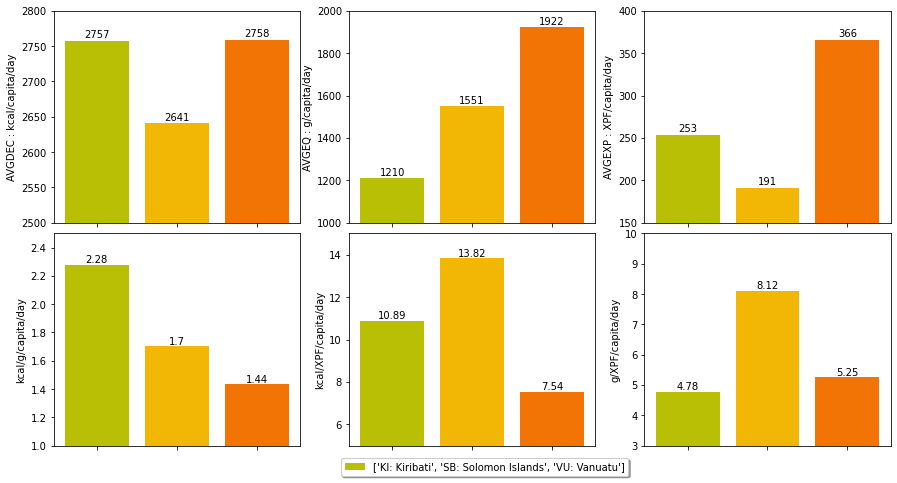

In [12]:
## GRAPHIQUE n°1.1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8)) 
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=45)


bar_colors = ['#B9BF04', '#F2B705', '#F27405']
bar_labels = ['KI: Kiribati', 'SB: Solomon Islands', 'VU: Vanuatu']

## 1
axes[0,0].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day'], label = bar_labels, color=bar_colors)
axes[0,0].set_ylabel('AVGDEC : kcal/capita/day')
axes[0,0].set_ylim(2500,2800) 
axes[0,0].set_xticklabels([])

rects = axes[0,0].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/capita/day']):
    height = rect.get_height()
    axes[0,0].text(rect.get_x() + rect.get_width() / 2, height + 2, round(label), ha="center", va="bottom")

## 2
axes[0,1].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day'], label = bar_labels, color=bar_colors)
axes[0,1].set_ylabel('AVGEQ : g/capita/day')
axes[0,1].set_ylim(1000,2000) 
axes[0,1].set_xticklabels([])

rects = axes[0,1].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/capita/day']):
    height = rect.get_height()
    axes[0,1].text(rect.get_x() + rect.get_width() / 2, height + 2, round(label), ha="center", va="bottom")

## 3
axes[0,2].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day'], label = bar_labels, color=bar_colors)
axes[0,2].set_ylabel('AVGEXP : XPF/capita/day')
axes[0,2].set_ylim(150,400) 
axes[0,2].set_xticklabels([])

rects = axes[0,2].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['XPF/capita/day']):
    height = rect.get_height()
    axes[0,2].text(
        rect.get_x() + rect.get_width() / 2, height + 2, round(label), ha="center", va="bottom")

## 4
axes[1,0].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/g/capita/day'], label = bar_labels, color=bar_colors)
axes[1,0].set_ylabel('kcal/g/capita/day')
axes[1,0].set_ylim(1,2.5) 
axes[1,0].set_xticklabels([])

rects = axes[1,0].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/g/capita/day']):
    height = rect.get_height()
    axes[1,0].text(rect.get_x() + rect.get_width() / 2, height, round(label,2), ha="center", va="bottom")

## 5
axes[1,1].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/XPF/capita/day'], label = bar_labels, color=bar_colors)
axes[1,1].set_ylabel('kcal/XPF/capita/day')
axes[1,1].set_ylim(5,15) 
axes[1,1].set_xticklabels([])

rects = axes[1,1].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['kcal/XPF/capita/day']):
    height = rect.get_height()
    axes[1,1].text(rect.get_x() + rect.get_width() / 2, height, round(label,2), ha="center", va="bottom")

## 6
axes[1,2].bar(df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP.index.values, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/XPF/capita/day'], label = bar_labels, color=bar_colors)
axes[1,2].set_ylabel('g/XPF/capita/day')
axes[1,2].set_ylim(3,10) 
axes[1,2].set_xticklabels([])

rects = axes[1,2].patches
for rect, label in zip(rects, df_gb_pays_total_AVGDEC_AVGEQ_AVGEXP['g/XPF/capita/day']):
    height = rect.get_height()
    axes[1,2].text(rect.get_x() + rect.get_width() / 2, height, round(label,2), ha="center", va="bottom")

## Légende
axes[0,0].legend(loc="center",bbox_to_anchor=(0,0,3.5,-2.3), ncol=3, fancybox=True, shadow=True)


In [13]:
## Analyse n°2
LISTE_PAYS = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]

df_pays_total_AVGDEC = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGDEC: Average Dietary Energy Consumption']

df_gb_pays_total_AVGDEC = df_pays_total_AVGDEC.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})

df_pivot_pays_total_AVGDEC = df_gb_pays_total_AVGDEC.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
df_pivot_pays_total_AVGDEC.loc[:,'Total'] = df_pivot_pays_total_AVGDEC.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGDEC = df_pivot_pays_total_AVGDEC.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGDEC = df_pivot_pays_total_AVGDEC.iloc[:, :].apply(lambda x: (x*100 / x.sum()))
df_pivot_pays_total_AVGDEC = df_pivot_pays_total_AVGDEC.drop('Total',axis=1)

GLOBAL_ORDER = df_pivot_pays_total_AVGDEC.index.to_list()


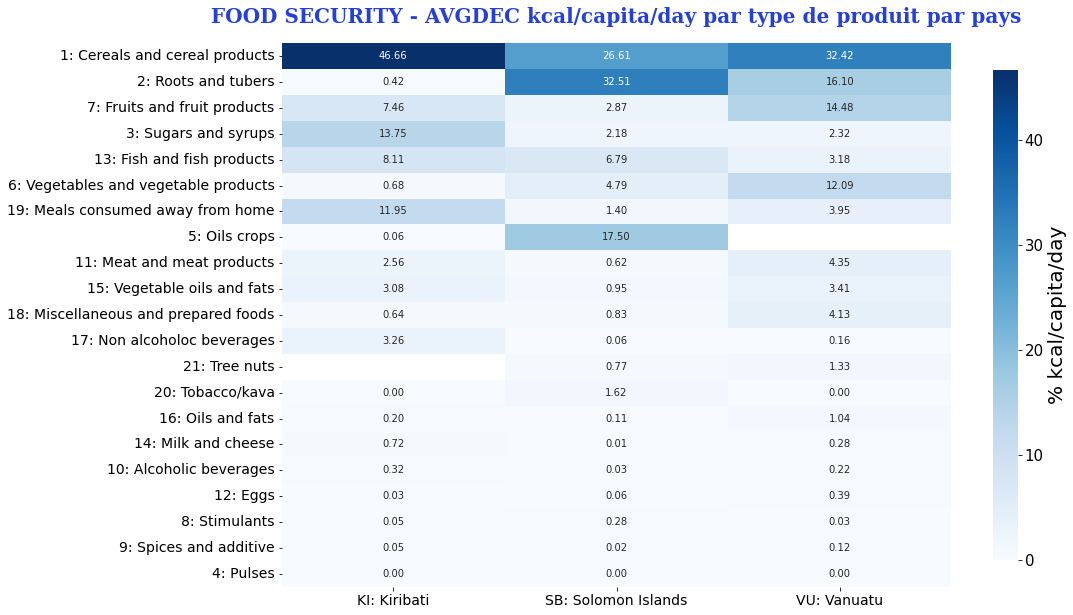

In [14]:
## GRAPHIQUE n°2.1

TITLE = "FOOD SECURITY - AVGDEC kcal/capita/day par type de produit par pays"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGDEC, annot=True, square=False, cmap="Blues", cbar_kws={'label': '% kcal/capita/day', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% kcal/capita/day', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
xb = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [15]:
## Analyse n°2
LISTE_PAYS = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]

df_pays_total_AVGEQ = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEQ: Average edible quantity']

df_gb_pays_total_AVGEQ = df_pays_total_AVGEQ.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})

df_pivot_pays_total_AVGEQ = df_gb_pays_total_AVGEQ.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
df_pivot_pays_total_AVGEQ.loc[:,'Total'] = df_pivot_pays_total_AVGEQ.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.iloc[:, :].apply(lambda x: (x*100 / x.sum()))
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.drop('Total',axis=1)
df_pivot_pays_total_AVGEQ = df_pivot_pays_total_AVGEQ.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_total_AVGDEC)

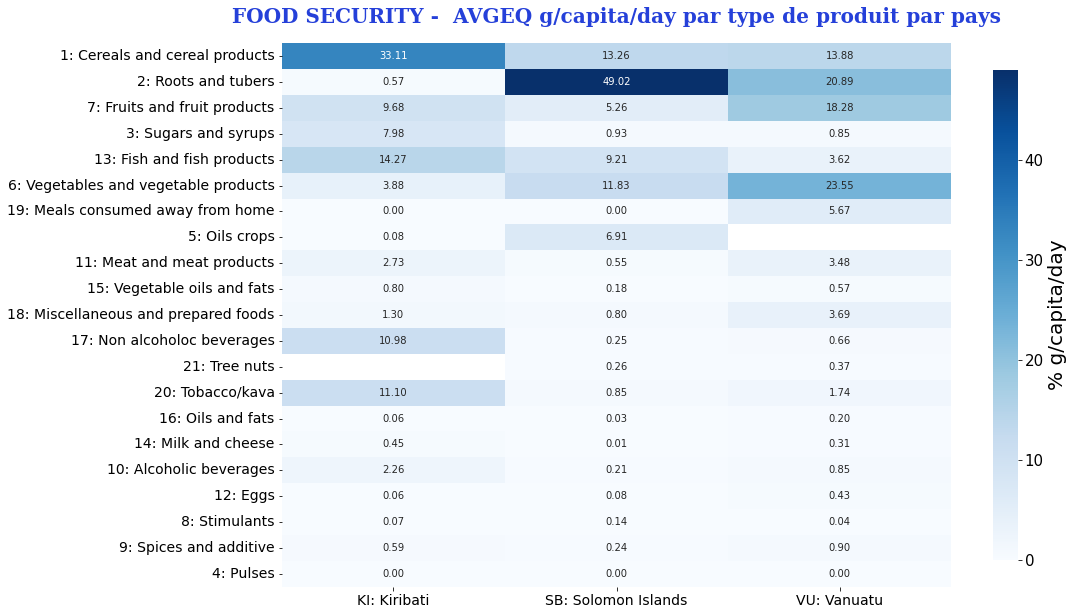

In [16]:
## GRAPHIQUE n°2.2
TITLE = "FOOD SECURITY -  AVGEQ g/capita/day par type de produit par pays"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGEQ, annot=True, square=False, cmap="Blues", cbar_kws={'label': '% g/capita/day', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% g/capita/day', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
xb = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [17]:
# Analyse n°2
LISTE_PAYS = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]

df_pays_total_AVGEXP = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGEXP: Average expenditures']

df_gb_pays_total_AVGEXP = df_pays_total_AVGEXP.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"kcal/capita/day"})

df_pivot_pays_total_AVGEXP = df_gb_pays_total_AVGEXP.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='kcal/capita/day')
df_pivot_pays_total_AVGEXP.loc[:,'Total'] = df_pivot_pays_total_AVGEXP.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.iloc[:, :].apply(lambda x: (x*100 / x.sum()))
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.drop('Total',axis=1)
df_pivot_pays_total_AVGEXP = df_pivot_pays_total_AVGEXP.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_total_AVGDEC)

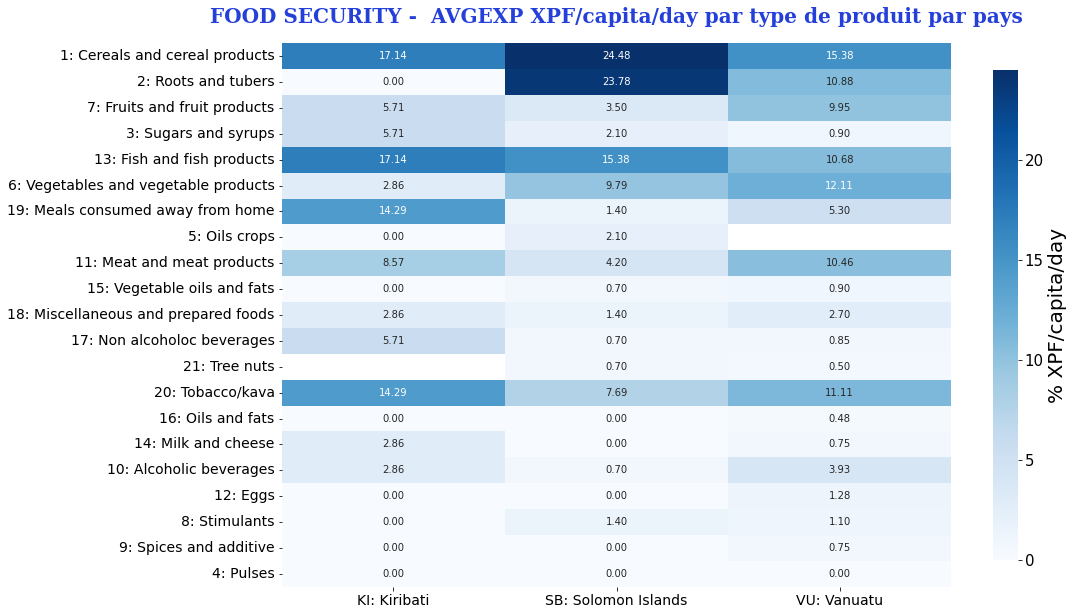

In [18]:
## GRAPHIQUE n°2.3
TITLE = "FOOD SECURITY -  AVGEXP XPF/capita/day par type de produit par pays"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGEXP, annot=True, square=False, cmap="Blues", cbar_kws={'label': '% XPF/capita/day', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('% XPF/capita/day', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [19]:
## Analyse n°3
LISTE_PAYS = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]

df_pays_total_AVGNPRDCONS = df_pays_total[df_pays_total['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']

df_gb_pays_total_AVGNPRDCONS = df_pays_total_AVGNPRDCONS.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})

df_pivot_pays_total_AVGNPRDCONS= df_gb_pays_total_AVGNPRDCONS.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_AVGNPRDCONS.loc[:,'Total'] = df_pivot_pays_total_AVGNPRDCONS.sum(numeric_only=True, axis=1)
df_pivot_pays_total_AVGNPRDCONS = df_pivot_pays_total_AVGNPRDCONS.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_AVGNPRDCONS = df_pivot_pays_total_AVGNPRDCONS.drop('Total',axis=1)
df_pivot_pays_total_AVGNPRDCONS = df_pivot_pays_total_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_total_AVGNPRDCONS)

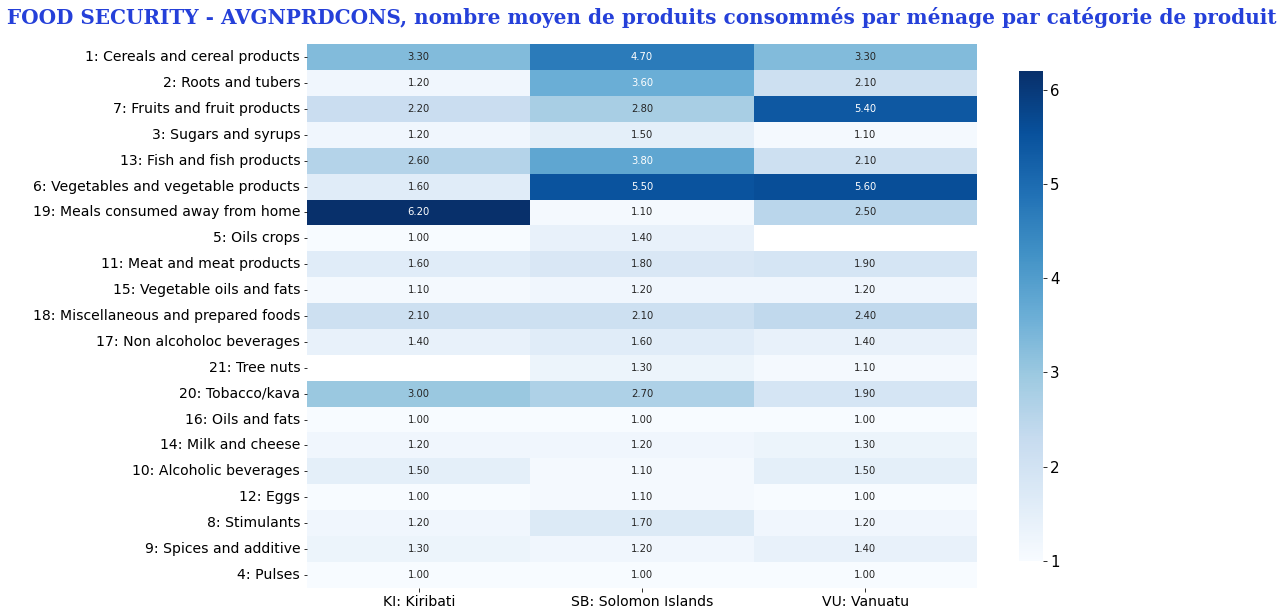

In [20]:
## GRAPHIQUE n°3.1
TITLE = "FOOD SECURITY - AVGNPRDCONS, nombre moyen de produits consommés par ménage par catégorie de produit"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_AVGNPRDCONS, annot=True, square=False, cmap="Blues", cbar_kws={'label': '', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

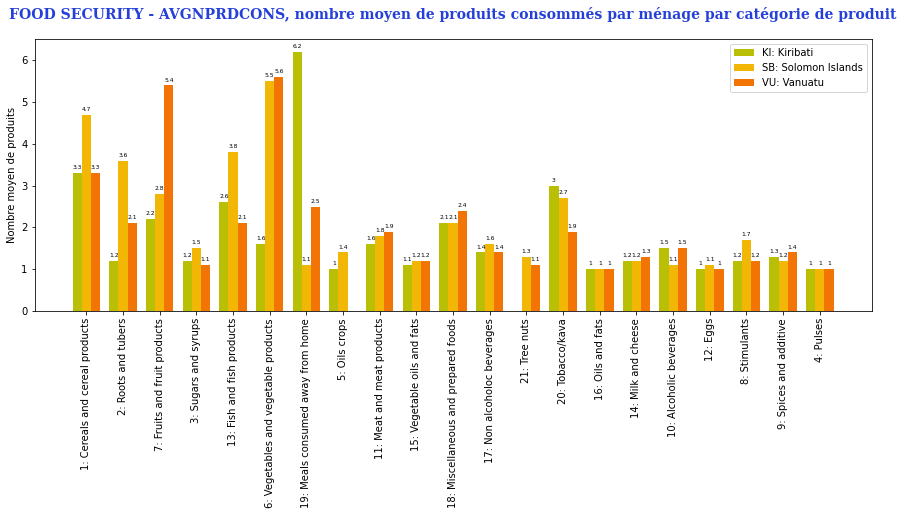

In [21]:
## GRAPHIQUE n°3.2
TITLE = "FOOD SECURITY - AVGNPRDCONS, nombre moyen de produits consommés par ménage par catégorie de produit"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5)) # Nombre et disposition des zones de dessin
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()

pays = {
    'KI: Kiribati': df_pivot_pays_total_AVGNPRDCONS['KI: Kiribati'].to_list(),
    'SB: Solomon Islands': df_pivot_pays_total_AVGNPRDCONS['SB: Solomon Islands'].to_list(),
    'VU: Vanuatu': df_pivot_pays_total_AVGNPRDCONS['VU: Vanuatu'].to_list(),
}

x = np.arange(len(categories))
width = 0.25  
multiplier = 0
bar_colors = ['#B9BF04', '#F2B705', '#F27405']

i=0
for attribute, measurement in pays.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=6)
    multiplier += 1
    i+=1


ax.set_ylabel('Nombre moyen de produits')
# ax.set_title('Catégories')
ax.set_xticks(x + width, categories)
ax.legend(loc='upper right')
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
# ax.set_ylim(0, 250)

In [22]:
# Analyse n°3
LISTE_PAYS = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]

df_pays_total_CONSAL1 = df_pays_total[df_pays_total['INDICATEUR'] == 'CONSAL1: Percentage of HH who consumed at least one product of the group']

df_gb_pays_total_CONSAL1 = df_pays_total_CONSAL1.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})

df_pivot_pays_total_CONSAL1= df_gb_pays_total_CONSAL1.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_CONSAL1.loc[:,'Total'] = df_pivot_pays_total_CONSAL1.sum(numeric_only=True, axis=1)
df_pivot_pays_total_CONSAL1 = df_pivot_pays_total_CONSAL1.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_CONSAL1 = df_pivot_pays_total_CONSAL1.drop('Total',axis=1)
df_pivot_pays_total_CONSAL1 = df_pivot_pays_total_CONSAL1.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_total_CONSAL1)

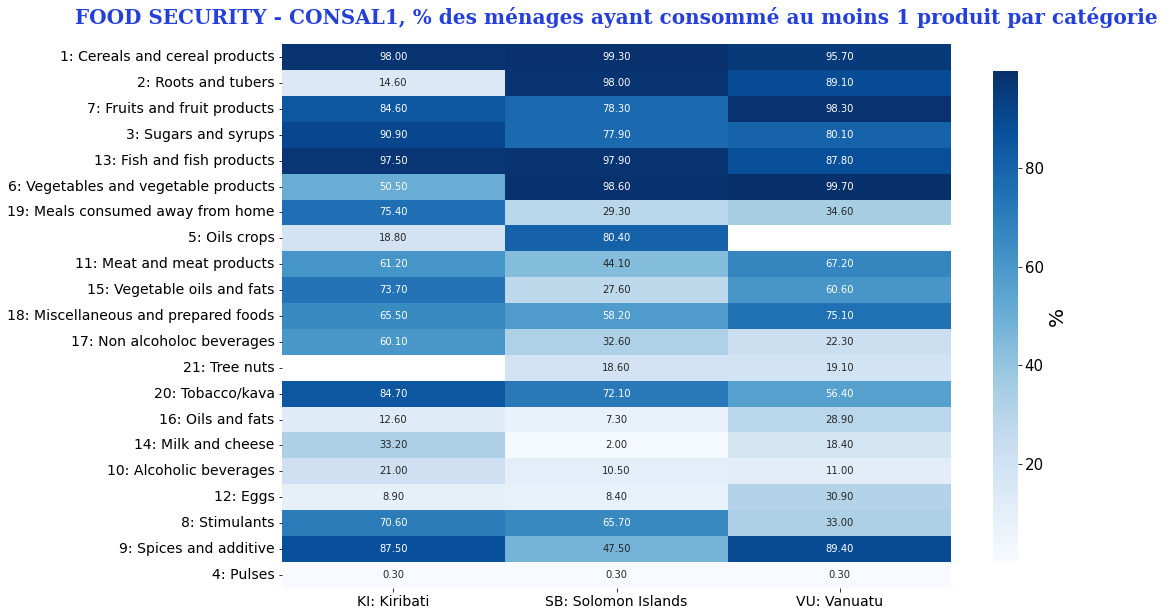

In [23]:
## GRAPHIQUE n°3.3
TITLE = "FOOD SECURITY - CONSAL1, % des ménages ayant consommé au moins 1 produit par catégorie"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_CONSAL1, annot=True, square=False, cmap="Blues", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)
xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [24]:
# Analyse n°3
LISTE_PAYS = ['KI: Kiribati','SB: Solomon Islands','VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_total = df_pays.loc[(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]

## CONSLTAVG
df_pays_total_CONSLTAVG = df_pays_total[df_pays_total['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']

df_gb_pays_total_CONSLTAVG = df_pays_total_CONSLTAVG.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})

df_pivot_pays_total_CONSLTAVG= df_gb_pays_total_CONSLTAVG.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_CONSLTAVG.loc[:,'Total'] = df_pivot_pays_total_CONSLTAVG.sum(numeric_only=True, axis=1)
df_pivot_pays_total_CONSLTAVG = df_pivot_pays_total_CONSLTAVG.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_CONSLTAVG = df_pivot_pays_total_CONSLTAVG.drop('Total',axis=1)
df_pivot_pays_total_CONSLTAVG = df_pivot_pays_total_CONSLTAVG.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_total_CONSLTAVG)

## CONSGTAVG
df_pays_total_CONSGTAVG = df_pays_total[df_pays_total['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']

df_gb_pays_total_CONSGTAVG = df_pays_total_CONSGTAVG.groupby(['REGION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})

df_pivot_pays_total_CONSGTAVG= df_gb_pays_total_CONSGTAVG.pivot_table(columns='REGION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_total_CONSGTAVG.loc[:,'Total'] = df_pivot_pays_total_CONSGTAVG.sum(numeric_only=True, axis=1)
df_pivot_pays_total_CONSGTAVG = df_pivot_pays_total_CONSGTAVG.sort_values(by=['Total'], ascending=False)
df_pivot_pays_total_CONSGTAVG = df_pivot_pays_total_CONSGTAVG.drop('Total',axis=1)
df_pivot_pays_total_CONSGTAVG = df_pivot_pays_total_CONSGTAVG.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_total_CONSGTAVG)

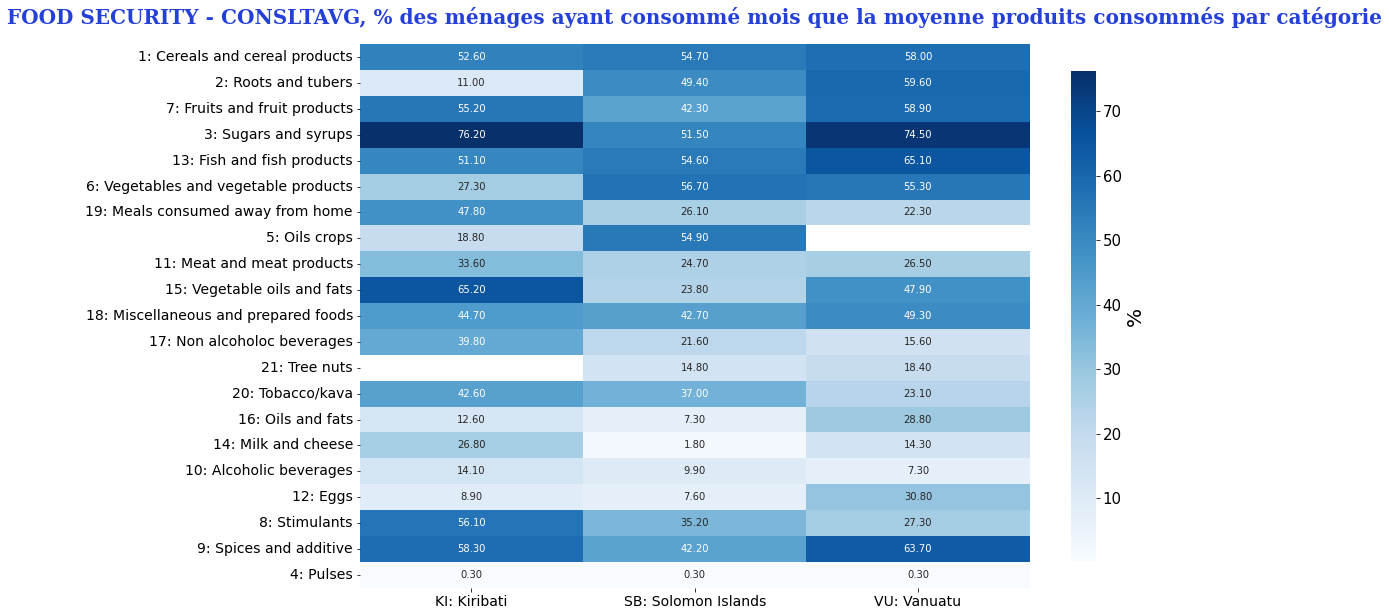

In [25]:
## GRAPHIQUE n°3.4
TITLE = "FOOD SECURITY - CONSLTAVG, % des ménages ayant consommé mois que la moyenne produits consommés par catégorie"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_CONSLTAVG, annot=True, square=False, cmap="Blues", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)

xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

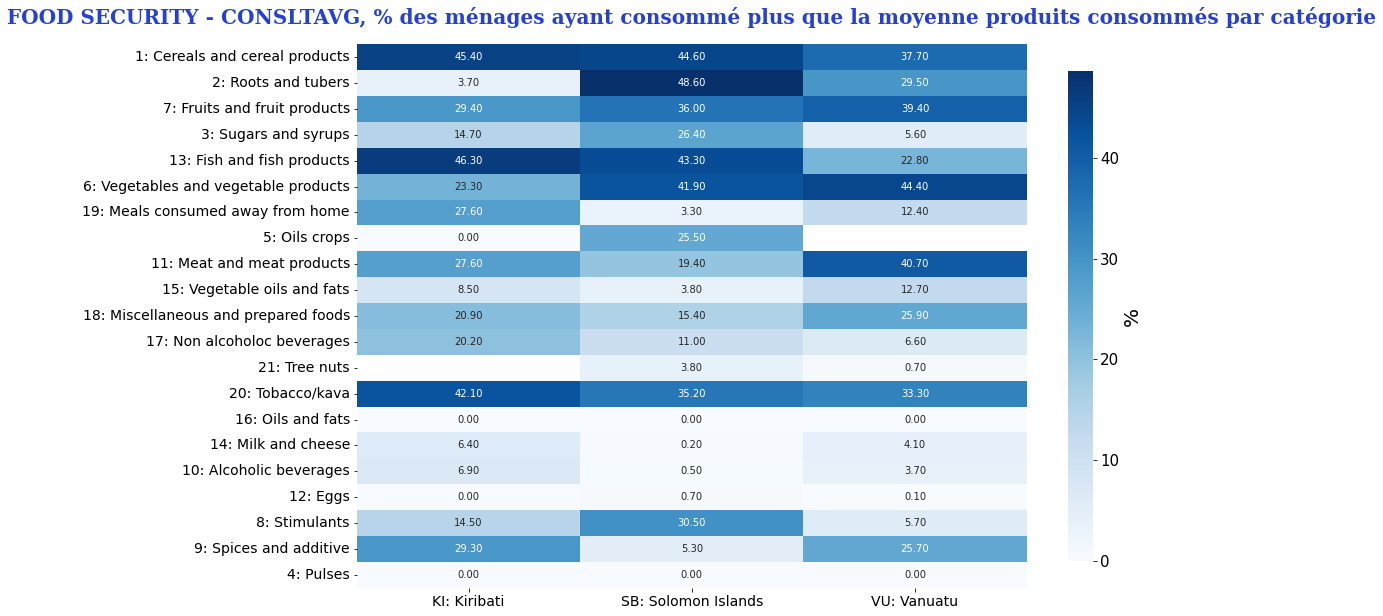

In [26]:
## GRAPHIQUE n°3.5
TITLE = "FOOD SECURITY - CONSLTAVG, % des ménages ayant consommé plus que la moyenne produits consommés par catégorie"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_pays_total_CONSGTAVG, annot=True, square=False, cmap="Blues", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f')
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel('%', size=20)
ax.figure.axes[-1].tick_params(labelsize=15)

xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

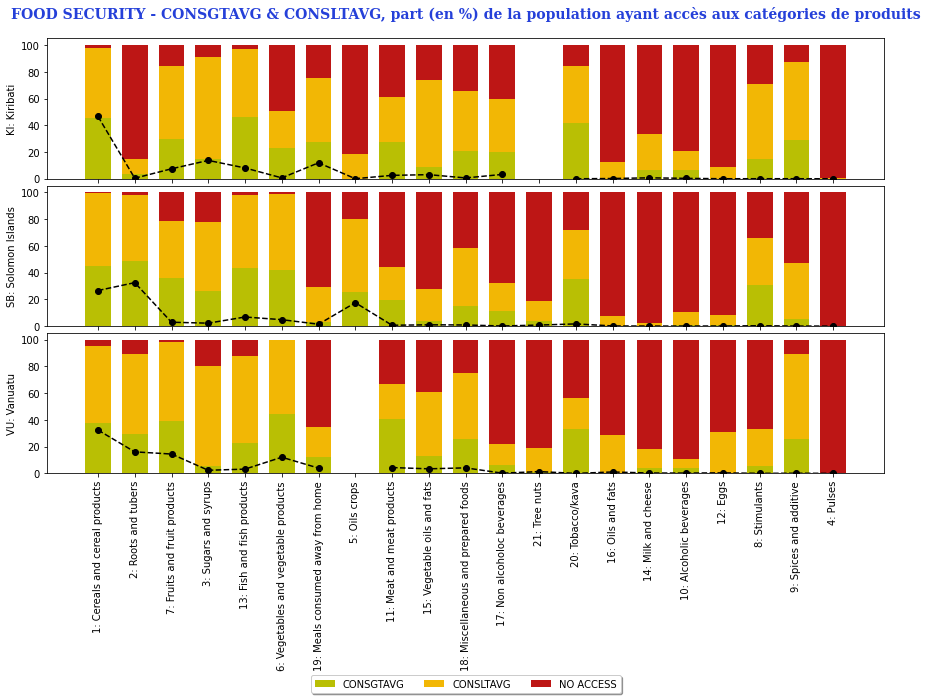

In [27]:
## GRAPHIQUE n°3.6
TITLE = "FOOD SECURITY - CONSGTAVG & CONSLTAVG, part (en %) de la population ayant accès aux catégories de produits"
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,8)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)

ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

width = 0.7
categories = df_pivot_pays_total_CONSLTAVG.index.to_list()
bar_colors = ['#B9BF04', '#F2B705', '#BD1615']

## 1
NO_ACCESS_KI = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_total_CONSGTAVG['KI: Kiribati'].to_list(), df_pivot_pays_total_CONSLTAVG['KI: Kiribati'].to_list())]
pourcentages_KI = {"CONSGTAVG": df_pivot_pays_total_CONSGTAVG['KI: Kiribati'].to_list(),
                   "CONSLTAVG": df_pivot_pays_total_CONSLTAVG['KI: Kiribati'].to_list(),
                   "NO ACCESS": NO_ACCESS_KI,
                  }

i=0
bottom_ki = np.zeros(len(df_pivot_pays_total_CONSLTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_KI.items():
    p = ax[0].bar(categories, pourcentage, width, label=boolean, bottom=bottom_ki, color=bar_colors[i])
    bottom_ki += pourcentage
    i += 1

ax[0].plot(df_pivot_pays_total_AVGDEC.index.values, df_pivot_pays_total_AVGDEC['KI: Kiribati'], 'black',linestyle='--', marker='o',linewidth=1.5)
ax[0].set_xticklabels([])
ax[0].set_ylabel('KI: Kiribati')

## 2
NO_ACCESS_SB = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_total_CONSGTAVG['SB: Solomon Islands'].to_list(), df_pivot_pays_total_CONSLTAVG['SB: Solomon Islands'].to_list())]
pourcentages_SB = {"CONSGTAVG": df_pivot_pays_total_CONSGTAVG['SB: Solomon Islands'].to_list(),
                   "CONSLTAVG": df_pivot_pays_total_CONSLTAVG['SB: Solomon Islands'].to_list(),
                   "NO ACCESS": NO_ACCESS_SB,
                  }

i=0
bottom_sb = np.zeros(len(df_pivot_pays_total_CONSLTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_SB.items():
    p = ax[1].bar(categories, pourcentage, width, label=boolean, bottom=bottom_sb, color=bar_colors[i])
    bottom_sb += pourcentage
    i += 1

ax[1].plot(df_pivot_pays_total_AVGDEC.index.values, df_pivot_pays_total_AVGDEC['SB: Solomon Islands'], 'black',linestyle='--', marker='o',linewidth=1.5)
ax[1].set_xticklabels([])
ax[1].set_ylabel('SB: Solomon Islands')

## 3
NO_ACCESS_VU = [100 - (a_i + b_i) for a_i, b_i in zip(df_pivot_pays_total_CONSGTAVG['VU: Vanuatu'].to_list(), df_pivot_pays_total_CONSLTAVG['VU: Vanuatu'].to_list())]
pourcentages_VU = {"CONSGTAVG": df_pivot_pays_total_CONSGTAVG['VU: Vanuatu'].to_list(),
                   "CONSLTAVG": df_pivot_pays_total_CONSLTAVG['VU: Vanuatu'].to_list(),
                   "NO ACCESS": NO_ACCESS_VU,
                  }

i=0
bottom_vu = np.zeros(len(df_pivot_pays_total_CONSLTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_VU.items():
    p = ax[2].bar(categories, pourcentage, width, label=boolean, bottom=bottom_vu, color=bar_colors[i])
    bottom_vu += pourcentage
    i += 1

ax[2].plot(df_pivot_pays_total_AVGDEC.index.values, df_pivot_pays_total_AVGDEC['VU: Vanuatu'], 'black',linestyle='--', marker='o',linewidth=1.5)
ax[2].set_ylabel('VU: Vanuatu')

## Légende
ax[0].legend(loc="center",bbox_to_anchor=(0,0,1,-7.2), ncol=3, fancybox=True, shadow=True)

In [28]:
## Analyse n°4
LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_sex = df_pays.loc[#(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_sex_AVGNPRDCONS = df_pays_sex[df_pays_sex['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_sex_AVGNPRDCONS = df_pays_sex_AVGNPRDCONS.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_AVGNPRDCONS= df_pays_sex_AVGNPRDCONS.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_AVGNPRDCONS = df_pivot_pays_sex_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_age_AVGNPRDCONS)

## CONSLTAVG
df_pays_sex_CONSLTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_sex_CONSLTAVG = df_pays_sex_CONSLTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSLTAVG= df_pays_sex_CONSLTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSLTAVG = df_pivot_pays_sex_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_sex_CONSLTAVG['ECART']=df_pivot_pays_sex_CONSLTAVG['M: Male']-df_pivot_pays_sex_CONSLTAVG['F: Female']
# print(df_pivot_pays_age_CONSLTAVG)

## CONSGTAVG
df_pays_sex_CONSGTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_sex_CONSGTAVG = df_pays_sex_CONSGTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSGTAVG= df_pays_sex_CONSGTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSGTAVG = df_pivot_pays_sex_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_sex_CONSGTAVG['ECART']=df_pivot_pays_sex_CONSGTAVG['M: Male']-df_pivot_pays_sex_CONSGTAVG['F: Female']
# print(df_pivot_pays_age_CONSGTAVG)

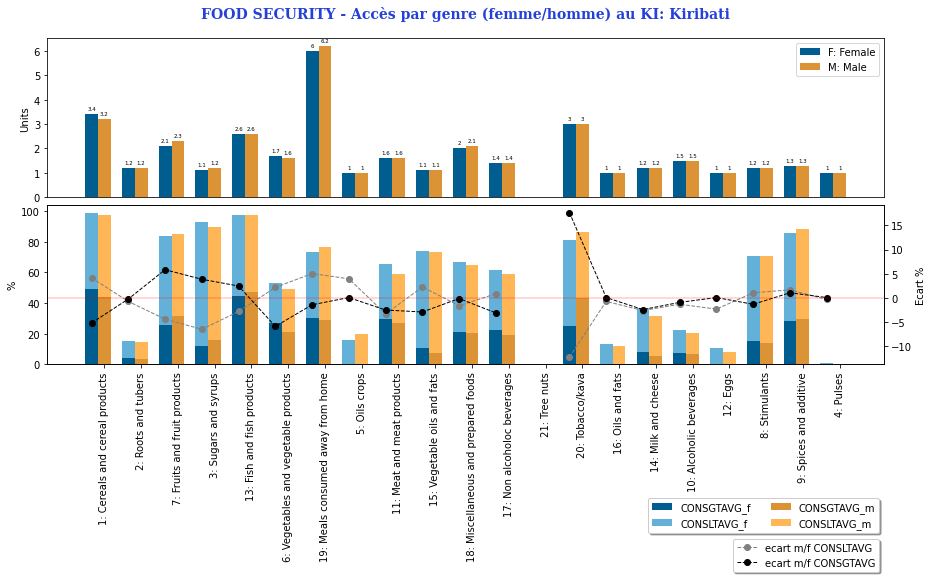

In [29]:
## GRAPHIQUE n°4.1
TITLE = "FOOD SECURITY - Accès par genre (femme/homme) au KI: Kiribati"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
genre = {'F: Female': df_pivot_pays_sex_AVGNPRDCONS['F: Female'].to_list(),
         'M: Male': df_pivot_pays_sex_AVGNPRDCONS['M: Male'].to_list(),
#          'T: Total': df_pivot_pays_age_AVGNPRDCONS['_T: Total'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

bar_colors = ['#005D8F', '#DB9335']
i=0
for attribute, measurement in genre.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticks([])

## 2 
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_f = ['#005D8F', '#63B0D9', '#E15F5C']
bar_colors_m = ['#DB9335', '#FFB657', '#E15F5C']


pourcentages_f= {"CONSGTAVG_f": df_pivot_pays_sex_CONSGTAVG['F: Female'].to_list(),
                 "CONSLTAVG_f": df_pivot_pays_sex_CONSLTAVG['F: Female'].to_list(),
                }


pourcentages_m= {"CONSGTAVG_m": df_pivot_pays_sex_CONSGTAVG['M: Male'].to_list(),
                 "CONSLTAVG_m": df_pivot_pays_sex_CONSLTAVG['M: Male'].to_list(),
}

x = np.arange(len(categories))
i=0
bottom_f = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_f.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_f, color=bar_colors_f[i])
    bottom_f += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_sex_CONSLTAVG.index.values, df_pivot_pays_sex_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.plot(df_pivot_pays_sex_CONSGTAVG.index.values, df_pivot_pays_sex_CONSGTAVG['ECART'], 'black',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSGTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')
ax2.set_ylabel('Ecart %')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [30]:
# Analyse n°4
# LISTE_PAYS = ['KI: Kiribati']
LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_sex = df_pays.loc[#(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_sex_AVGNPRDCONS = df_pays_sex[df_pays_sex['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_sex_AVGNPRDCONS = df_pays_sex_AVGNPRDCONS.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_AVGNPRDCONS= df_pays_sex_AVGNPRDCONS.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_AVGNPRDCONS = df_pivot_pays_sex_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_age_AVGNPRDCONS)

## CONSLTAVG
df_pays_sex_CONSLTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_sex_CONSLTAVG = df_pays_sex_CONSLTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSLTAVG= df_pays_sex_CONSLTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSLTAVG = df_pivot_pays_sex_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_sex_CONSLTAVG['ECART']=df_pivot_pays_sex_CONSLTAVG['M: Male']-df_pivot_pays_sex_CONSLTAVG['F: Female']
# print(df_pivot_pays_age_CONSLTAVG)

## CONSGTAVG
df_pays_sex_CONSGTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_sex_CONSGTAVG = df_pays_sex_CONSGTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSGTAVG= df_pays_sex_CONSGTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSGTAVG = df_pivot_pays_sex_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_sex_CONSGTAVG['ECART']=df_pivot_pays_sex_CONSGTAVG['M: Male']-df_pivot_pays_sex_CONSGTAVG['F: Female']
# print(df_pivot_pays_age_CONSGTAVG)

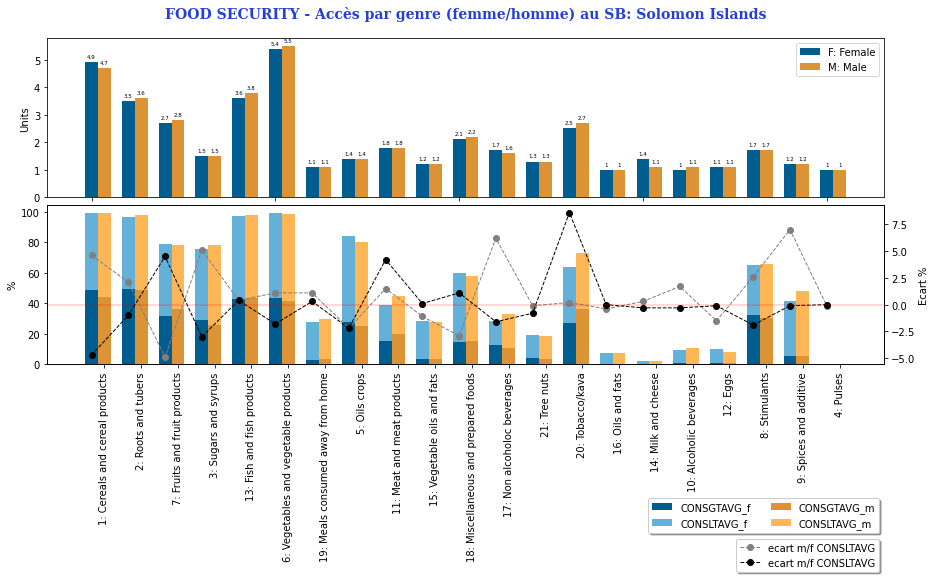

In [31]:
## GRAPHIQUE n°4.2
TITLE = "FOOD SECURITY - Accès par genre (femme/homme) au SB: Solomon Islands"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
genre = {'F: Female': df_pivot_pays_sex_AVGNPRDCONS['F: Female'].to_list(),
         'M: Male': df_pivot_pays_sex_AVGNPRDCONS['M: Male'].to_list(),
#          'T: Total': df_pivot_pays_age_AVGNPRDCONS['_T: Total'].to_list(),
}

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

bar_colors = ['#005D8F', '#DB9335']
i=0
for attribute, measurement in genre.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2 
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_f = ['#005D8F', '#63B0D9', '#E15F5C']
bar_colors_m = ['#DB9335', '#FFB657', '#E15F5C']

pourcentages_f= {"CONSGTAVG_f": df_pivot_pays_sex_CONSGTAVG['F: Female'].to_list(),
                 "CONSLTAVG_f": df_pivot_pays_sex_CONSLTAVG['F: Female'].to_list(),
                }

pourcentages_m= {"CONSGTAVG_m": df_pivot_pays_sex_CONSGTAVG['M: Male'].to_list(),
                 "CONSLTAVG_m": df_pivot_pays_sex_CONSLTAVG['M: Male'].to_list(),
                }

x = np.arange(len(categories))

i=0
bottom_f = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_f.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_f, color=bar_colors_f[i])
    bottom_f += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_sex_CONSLTAVG.index.values, df_pivot_pays_sex_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.plot(df_pivot_pays_sex_CONSGTAVG.index.values, df_pivot_pays_sex_CONSGTAVG['ECART'], 'black',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')
ax2.set_ylabel('Ecart %', )

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [32]:
# Analyse n°4
# LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_sex = df_pays.loc[#(df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_sex_AVGNPRDCONS = df_pays_sex[df_pays_sex['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_sex_AVGNPRDCONS = df_pays_sex_AVGNPRDCONS.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_AVGNPRDCONS= df_pays_sex_AVGNPRDCONS.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_AVGNPRDCONS = df_pivot_pays_sex_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_age_AVGNPRDCONS)

## CONSLTAVG
df_pays_sex_CONSLTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_sex_CONSLTAVG = df_pays_sex_CONSLTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSLTAVG= df_pays_sex_CONSLTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSLTAVG = df_pivot_pays_sex_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_sex_CONSLTAVG['ECART']=df_pivot_pays_sex_CONSLTAVG['M: Male']-df_pivot_pays_sex_CONSLTAVG['F: Female']
# print(df_pivot_pays_age_CONSLTAVG)

## CONSGTAVG
df_pays_sex_CONSGTAVG = df_pays_sex[df_pays_sex['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_sex_CONSGTAVG = df_pays_sex_CONSGTAVG.groupby(['GENRE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_sex_CONSGTAVG= df_pays_sex_CONSGTAVG.pivot_table(columns='GENRE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_sex_CONSGTAVG = df_pivot_pays_sex_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_sex_CONSGTAVG['ECART']=df_pivot_pays_sex_CONSGTAVG['M: Male']-df_pivot_pays_sex_CONSGTAVG['F: Female']
# print(df_pivot_pays_age_CONSGTAVG)

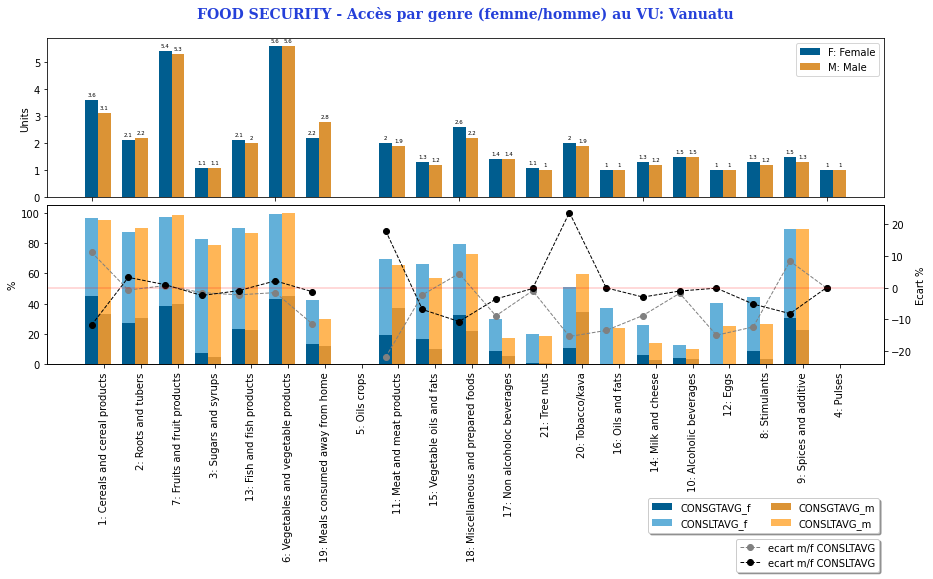

In [33]:
## GRAPHIQUE 4.3
TITLE = "FOOD SECURITY - Accès par genre (femme/homme) au VU: Vanuatu"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
genre = {'F: Female': df_pivot_pays_sex_AVGNPRDCONS['F: Female'].to_list(),
         'M: Male': df_pivot_pays_sex_AVGNPRDCONS['M: Male'].to_list(),
#          'T: Total': df_pivot_pays_age_AVGNPRDCONS['_T: Total'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#005D8F', '#DB9335']

i=0
for attribute, measurement in genre.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_f = ['#005D8F', '#63B0D9', '#E15F5C']
bar_colors_m = ['#DB9335', '#FFB657', '#E15F5C']

pourcentages_f= {"CONSGTAVG_f": df_pivot_pays_sex_CONSGTAVG['F: Female'].to_list(),
                 "CONSLTAVG_f": df_pivot_pays_sex_CONSLTAVG['F: Female'].to_list(),
                }

pourcentages_m= {"CONSGTAVG_m": df_pivot_pays_sex_CONSGTAVG['M: Male'].to_list(),
                 "CONSLTAVG_m": df_pivot_pays_sex_CONSLTAVG['M: Male'].to_list(),
                }

x = np.arange(len(categories))

i=0
bottom_f = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_f.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_f, color=bar_colors_f[i])
    bottom_f += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_sex_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_sex_CONSLTAVG.index.values, df_pivot_pays_sex_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.plot(df_pivot_pays_sex_CONSGTAVG.index.values, df_pivot_pays_sex_CONSGTAVG['ECART'], 'black',linestyle='--', marker='o',linewidth=1, label='ecart m/f CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')
ax2.set_ylabel('Ecart %', )

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [34]:
# Analyse n°5
LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_age = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
#                             (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_age_AVGNPRDCONS = df_pays_age[df_pays_age['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_age_AVGNPRDCONS = df_pays_age_AVGNPRDCONS.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_AVGNPRDCONS= df_pays_age_AVGNPRDCONS.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_AVGNPRDCONS = df_pivot_pays_age_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_age_AVGNPRDCONS)

## CONSLTAVG
df_pays_age_CONSLTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_age_CONSLTAVG = df_pays_age_CONSLTAVG.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_CONSLTAVG= df_pays_age_CONSLTAVG.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_CONSLTAVG = df_pivot_pays_age_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_age_CONSLTAVG['STD']=df_pivot_pays_age_CONSLTAVG.std(axis=1)
# print(df_pivot_pays_age_CONSLTAVG)

## CONSGTAVG
df_pays_age_CONSGTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_age_CONSGTAVG = df_pays_age_CONSGTAVG.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_CONSGTAVG= df_pays_age_CONSGTAVG.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_CONSGTAVG = df_pivot_pays_age_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_age_CONSGTAVG['STD']=df_pivot_pays_age_CONSGTAVG.std(axis=1)
# print(df_pivot_pays_age_CONSGTAVG)

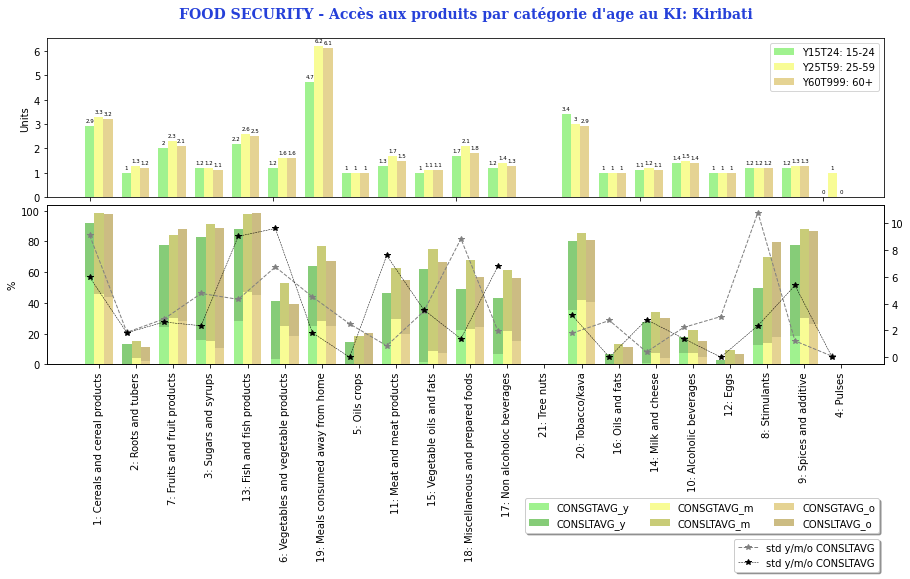

In [35]:
## GRAPHIQUE 5.1
TITLE = "FOOD SECURITY - Accès aux produits par catégorie d'age au KI: Kiribati"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
age = {'Y15T24: 15-24': df_pivot_pays_age_AVGNPRDCONS['Y15T24: 15-24'].to_list(),
       'Y25T59: 25-59': df_pivot_pays_age_AVGNPRDCONS['Y25T59: 25-59'].to_list(),
       'Y60T999: 60+': df_pivot_pays_age_AVGNPRDCONS['Y60T999: 60+'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
bar_colors = ['#A0F28F', '#F8FC95','#E5D393']

i=0
for attribute, measurement in age.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.25
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_j = ['#A0F28F', '#86CC78']
bar_colors_m = ['#F8FC95', '#C9CC78']
bar_colors_v = ['#E5D393', '#CCBC83']

pourcentages_j= {"CONSGTAVG_y": df_pivot_pays_age_CONSGTAVG['Y15T24: 15-24'].to_list(),
                 "CONSLTAVG_y": df_pivot_pays_age_CONSLTAVG['Y15T24: 15-24'].to_list(),
                }

pourcentages_m= {"CONSGTAVG_m": df_pivot_pays_age_CONSGTAVG['Y25T59: 25-59'].to_list(),
                 "CONSLTAVG_m": df_pivot_pays_age_CONSLTAVG['Y25T59: 25-59'].to_list(),
                }

pourcentages_v= {"CONSGTAVG_o": df_pivot_pays_age_CONSGTAVG['Y60T999: 60+'].to_list(),
                 "CONSLTAVG_o": df_pivot_pays_age_CONSLTAVG['Y60T999: 60+'].to_list(),
                }

x = np.arange(len(categories))

i=0
bottom_j = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_j.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_j, color=bar_colors_j[i])
    bottom_j += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

k=0
bottom_v = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_v.items():
    p = ax[1].bar(x+2*width, pourcentage, width, label=boolean, bottom=bottom_v, color=bar_colors_v[k])
    bottom_v += pourcentage
    k += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_age_CONSLTAVG.index.values, df_pivot_pays_age_CONSLTAVG['STD'], 'grey',linestyle='--', marker='*',linewidth=1, label='std y/m/o CONSLTAVG')
ax2.plot(df_pivot_pays_age_CONSGTAVG.index.values, df_pivot_pays_age_CONSGTAVG['STD'], 'black',linestyle='--', marker='*',linewidth=0.5, label='std y/m/o CONSLTAVG')

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=3, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [36]:
# Analyse n°5
# LISTE_PAYS = ['KI: Kiribati']
LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_age = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
#                             (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_age_AVGNPRDCONS = df_pays_age[df_pays_age['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_age_AVGNPRDCONS = df_pays_age_AVGNPRDCONS.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_AVGNPRDCONS= df_pays_age_AVGNPRDCONS.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_AVGNPRDCONS = df_pivot_pays_age_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_age_AVGNPRDCONS)

## CONSLTAVG
df_pays_age_CONSLTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_age_CONSLTAVG = df_pays_age_CONSLTAVG.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_CONSLTAVG= df_pays_age_CONSLTAVG.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_CONSLTAVG = df_pivot_pays_age_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_age_CONSLTAVG['STD']=df_pivot_pays_age_CONSLTAVG.std(axis=1)
# print(df_pivot_pays_age_CONSLTAVG)

## CONSGTAVG
df_pays_age_CONSGTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_age_CONSGTAVG = df_pays_age_CONSGTAVG.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_CONSGTAVG= df_pays_age_CONSGTAVG.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_CONSGTAVG = df_pivot_pays_age_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_age_CONSGTAVG['STD']=df_pivot_pays_age_CONSGTAVG.std(axis=1)
# print(df_pivot_pays_age_CONSGTAVG)

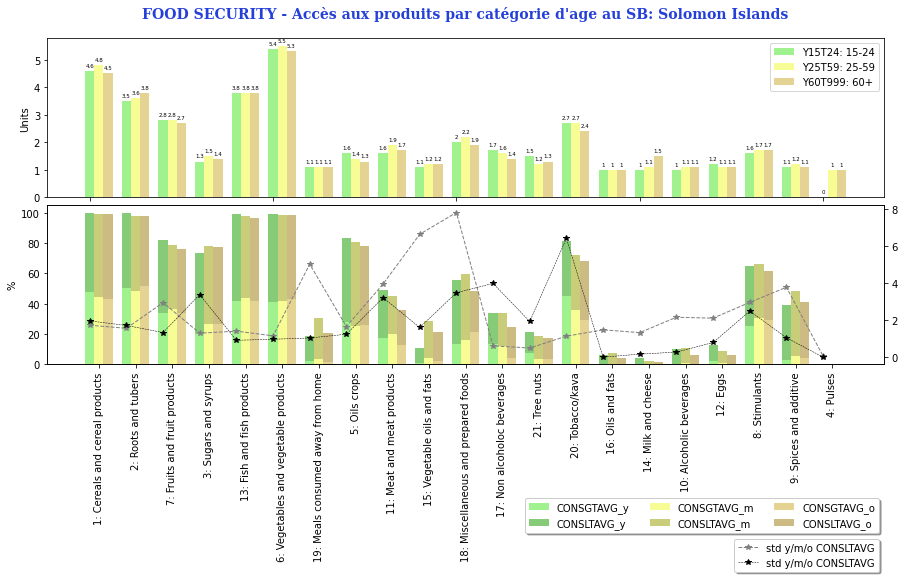

In [37]:
## GRAPHIQUE 5.2
TITLE = "FOOD SECURITY - Accès aux produits par catégorie d'age au SB: Solomon Islands"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
age = {'Y15T24: 15-24': df_pivot_pays_age_AVGNPRDCONS['Y15T24: 15-24'].to_list(),
       'Y25T59: 25-59': df_pivot_pays_age_AVGNPRDCONS['Y25T59: 25-59'].to_list(),
       'Y60T999: 60+': df_pivot_pays_age_AVGNPRDCONS['Y60T999: 60+'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
bar_colors = ['#A0F28F', '#F8FC95','#E5D393']

i=0
for attribute, measurement in age.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.25
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_j = ['#A0F28F', '#86CC78']
bar_colors_m = ['#F8FC95', '#C9CC78']
bar_colors_v = ['#E5D393', '#CCBC83']

pourcentages_j= {"CONSGTAVG_y": df_pivot_pays_age_CONSGTAVG['Y15T24: 15-24'].to_list(),
                 "CONSLTAVG_y": df_pivot_pays_age_CONSLTAVG['Y15T24: 15-24'].to_list(),
                }

pourcentages_m= {"CONSGTAVG_m": df_pivot_pays_age_CONSGTAVG['Y25T59: 25-59'].to_list(),
                 "CONSLTAVG_m": df_pivot_pays_age_CONSLTAVG['Y25T59: 25-59'].to_list(),
                }

pourcentages_v= {"CONSGTAVG_o": df_pivot_pays_age_CONSGTAVG['Y60T999: 60+'].to_list(),
                 "CONSLTAVG_o": df_pivot_pays_age_CONSLTAVG['Y60T999: 60+'].to_list(),
                }

x = np.arange(len(categories))

i=0
bottom_j = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_j.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_j, color=bar_colors_j[i])
    bottom_j += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

k=0
bottom_v = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_v.items():
    p = ax[1].bar(x+2*width, pourcentage, width, label=boolean, bottom=bottom_v, color=bar_colors_v[k])
    bottom_v += pourcentage
    k += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_age_CONSLTAVG.index.values, df_pivot_pays_age_CONSLTAVG['STD'], 'grey',linestyle='--', marker='*',linewidth=1, label='std y/m/o CONSLTAVG')
ax2.plot(df_pivot_pays_age_CONSGTAVG.index.values, df_pivot_pays_age_CONSGTAVG['STD'], 'black',linestyle='--', marker='*',linewidth=0.5, label='std y/m/o CONSLTAVG')

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=3, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [38]:
# Analyse n°5
# LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]

df_pays_age = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
#                             (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_age_AVGNPRDCONS = df_pays_age[df_pays_age['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_age_AVGNPRDCONS = df_pays_age_AVGNPRDCONS.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_AVGNPRDCONS= df_pays_age_AVGNPRDCONS.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_AVGNPRDCONS = df_pivot_pays_age_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_age_AVGNPRDCONS)

## CONSLTAVG
df_pays_age_CONSLTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_age_CONSLTAVG = df_pays_age_CONSLTAVG.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_CONSLTAVG= df_pays_age_CONSLTAVG.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_CONSLTAVG = df_pivot_pays_age_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_age_CONSLTAVG['STD']=df_pivot_pays_age_CONSLTAVG.std(axis=1)
# print(df_pivot_pays_age_CONSLTAVG)

## CONSGTAVG
df_pays_age_CONSGTAVG = df_pays_age[df_pays_age['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_age_CONSGTAVG = df_pays_age_CONSGTAVG.groupby(['AGE','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_age_CONSGTAVG= df_pays_age_CONSGTAVG.pivot_table(columns='AGE', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_age_CONSGTAVG = df_pivot_pays_age_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_age_CONSGTAVG['STD']=df_pivot_pays_age_CONSGTAVG.std(axis=1)
# print(df_pivot_pays_age_CONSGTAVG)

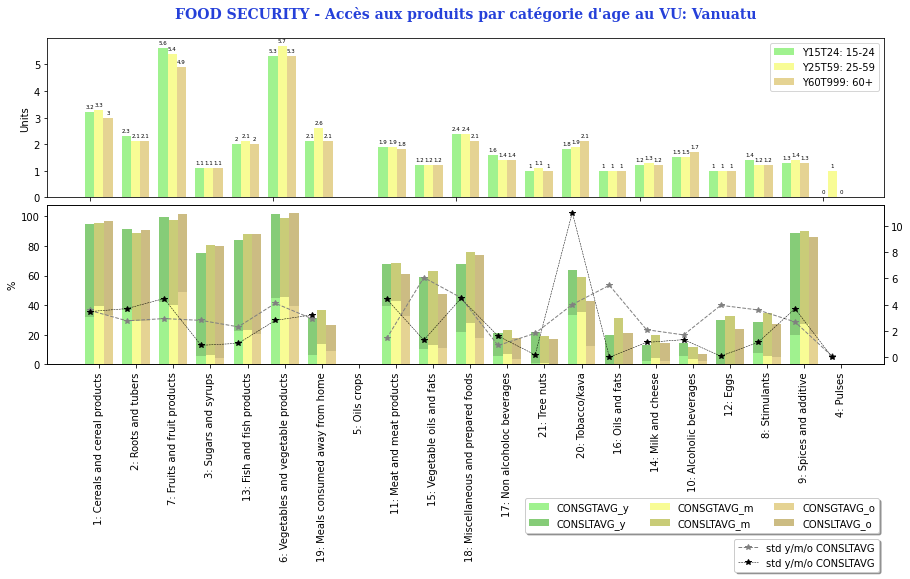

In [39]:
## GRAPHIQUE 5.3
TITLE = "FOOD SECURITY - Accès aux produits par catégorie d'age au VU: Vanuatu"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
age = {'Y15T24: 15-24': df_pivot_pays_age_AVGNPRDCONS['Y15T24: 15-24'].to_list(),
       'Y25T59: 25-59': df_pivot_pays_age_AVGNPRDCONS['Y25T59: 25-59'].to_list(),
       'Y60T999: 60+': df_pivot_pays_age_AVGNPRDCONS['Y60T999: 60+'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
bar_colors = ['#A0F28F', '#F8FC95','#E5D393']

i=0
for attribute, measurement in age.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.25
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_j = ['#A0F28F', '#86CC78']
bar_colors_m = ['#F8FC95', '#C9CC78']
bar_colors_v = ['#E5D393', '#CCBC83']

pourcentages_j= {"CONSGTAVG_y": df_pivot_pays_age_CONSGTAVG['Y15T24: 15-24'].to_list(),
                 "CONSLTAVG_y": df_pivot_pays_age_CONSLTAVG['Y15T24: 15-24'].to_list(),
                }

pourcentages_m= {"CONSGTAVG_m": df_pivot_pays_age_CONSGTAVG['Y25T59: 25-59'].to_list(),
                 "CONSLTAVG_m": df_pivot_pays_age_CONSLTAVG['Y25T59: 25-59'].to_list(),
                }

pourcentages_v= {"CONSGTAVG_o": df_pivot_pays_age_CONSGTAVG['Y60T999: 60+'].to_list(),
                 "CONSLTAVG_o": df_pivot_pays_age_CONSLTAVG['Y60T999: 60+'].to_list(),
                }

x = np.arange(len(categories))

i=0
bottom_j = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_j.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_j, color=bar_colors_j[i])
    bottom_j += pourcentage
    i += 1

j=0
bottom_m = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_m.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_m, color=bar_colors_m[j])
    bottom_m += pourcentage
    j += 1

k=0
bottom_v = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_v.items():
    p = ax[1].bar(x+2*width, pourcentage, width, label=boolean, bottom=bottom_v, color=bar_colors_v[k])
    bottom_v += pourcentage
    k += 1

ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_age_CONSLTAVG.index.values, df_pivot_pays_age_CONSLTAVG['STD'], 'grey',linestyle='--', marker='*',linewidth=1, label='std y/m/o CONSLTAVG')
ax2.plot(df_pivot_pays_age_CONSGTAVG.index.values, df_pivot_pays_age_CONSGTAVG['STD'], 'black',linestyle='--', marker='*',linewidth=0.5, label='std y/m/o CONSLTAVG')

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=3, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [40]:
## Analyse n°6
LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_urb = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
#                             (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_urb_AVGNPRDCONS = df_pays_urb[df_pays_urb['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_urb_AVGNPRDCONS = df_pays_urb_AVGNPRDCONS.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_AVGNPRDCONS= df_pays_urb_AVGNPRDCONS.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_AVGNPRDCONS = df_pivot_pays_urb_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_urb_AVGNPRDCONS)

## CONSLTAVG
df_pays_urb_CONSLTAVG = df_pays_urb[df_pays_urb['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_urb_CONSLTAVG = df_pays_urb_CONSLTAVG.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_CONSLTAVG= df_pays_urb_CONSLTAVG.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_CONSLTAVG = df_pivot_pays_urb_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_urb_CONSLTAVG['ECART']=df_pivot_pays_urb_CONSLTAVG['U: Urban']-df_pivot_pays_urb_CONSLTAVG['R: Rural']
# print(df_pivot_pays_urb_CONSLTAVG)

## CONSGTAVG
df_pays_urb_CONSGTAVG = df_pays_urb[df_pays_urb['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_urb_CONSGTAVG = df_pays_urb_CONSGTAVG.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_CONSGTAVG= df_pays_urb_CONSGTAVG.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_CONSGTAVG = df_pivot_pays_urb_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_urb_CONSGTAVG['ECART']=df_pivot_pays_urb_CONSGTAVG['U: Urban']-df_pivot_pays_urb_CONSGTAVG['R: Rural']
# print(df_pivot_pays_urb_CONSGTAVG)

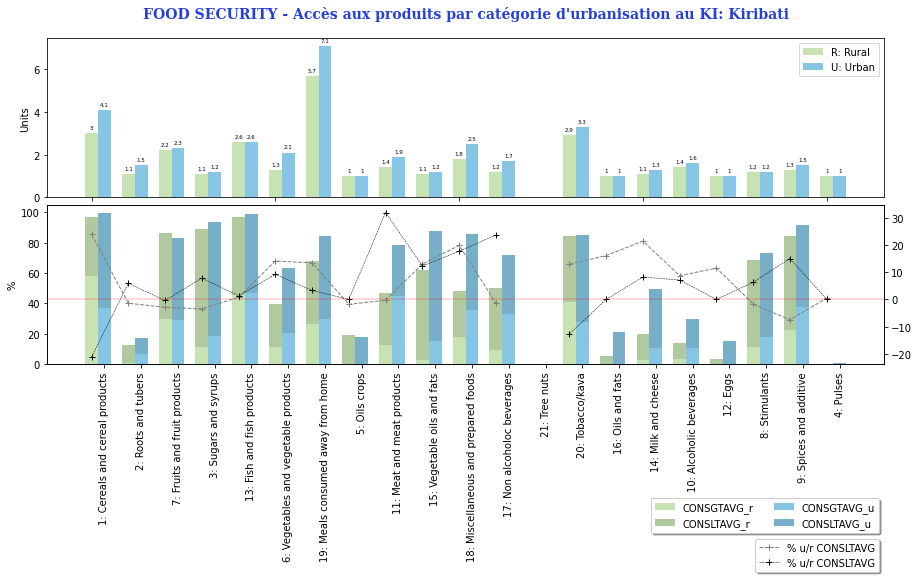

In [41]:
## GRAPHIQUE 6.1
TITLE = "FOOD SECURITY - Accès aux produits par catégorie d'urbanisation au KI: Kiribati"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
age = {'R: Rural': df_pivot_pays_urb_AVGNPRDCONS['R: Rural'].to_list(),
       'U: Urban': df_pivot_pays_urb_AVGNPRDCONS['U: Urban'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#C8E3B3', '#86C5E3']

i=0
for attribute, measurement in age.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_r = ['#C8E3B3', '#B1C99F']
bar_colors_u = ['#86C5E3', '#77AFC9']

pourcentages_r= {"CONSGTAVG_r": df_pivot_pays_urb_CONSGTAVG['R: Rural'].to_list(),
                 "CONSLTAVG_r": df_pivot_pays_urb_CONSLTAVG['R: Rural'].to_list(),
                }

pourcentages_u= {"CONSGTAVG_u": df_pivot_pays_urb_CONSGTAVG['U: Urban'].to_list(),
                 "CONSLTAVG_u": df_pivot_pays_urb_CONSLTAVG['U: Urban'].to_list(),
                }


x = np.arange(len(categories))

i=0
bottom_r = np.zeros(len(df_pivot_pays_urb_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_r.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_r, color=bar_colors_r[i])
    bottom_r += pourcentage
    i += 1

j=0
bottom_u = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_u.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_u, color=bar_colors_u[j])
    bottom_u += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_urb_CONSLTAVG.index.values, df_pivot_pays_urb_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% u/r CONSLTAVG')
ax2.plot(df_pivot_pays_urb_CONSGTAVG.index.values, df_pivot_pays_urb_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% u/r CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [42]:
## Analyse n°6
# LISTE_PAYS = ['KI: Kiribati']
LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_urb = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
#                             (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_urb_AVGNPRDCONS = df_pays_urb[df_pays_urb['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_urb_AVGNPRDCONS = df_pays_urb_AVGNPRDCONS.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_AVGNPRDCONS= df_pays_urb_AVGNPRDCONS.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_AVGNPRDCONS = df_pivot_pays_urb_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_urb_AVGNPRDCONS)

## CONSLTAVG
df_pays_urb_CONSLTAVG = df_pays_urb[df_pays_urb['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_urb_CONSLTAVG = df_pays_urb_CONSLTAVG.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_CONSLTAVG= df_pays_urb_CONSLTAVG.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_CONSLTAVG = df_pivot_pays_urb_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_urb_CONSLTAVG['ECART']=df_pivot_pays_urb_CONSLTAVG['U: Urban']-df_pivot_pays_urb_CONSLTAVG['R: Rural']
# print(df_pivot_pays_urb_CONSLTAVG)

## CONSGTAVG
df_pays_urb_CONSGTAVG = df_pays_urb[df_pays_urb['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_urb_CONSGTAVG = df_pays_urb_CONSGTAVG.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_CONSGTAVG= df_pays_urb_CONSGTAVG.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_CONSGTAVG = df_pivot_pays_urb_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_urb_CONSGTAVG['ECART']=df_pivot_pays_urb_CONSGTAVG['U: Urban']-df_pivot_pays_urb_CONSGTAVG['R: Rural']
# print(df_pivot_pays_urb_CONSGTAVG)

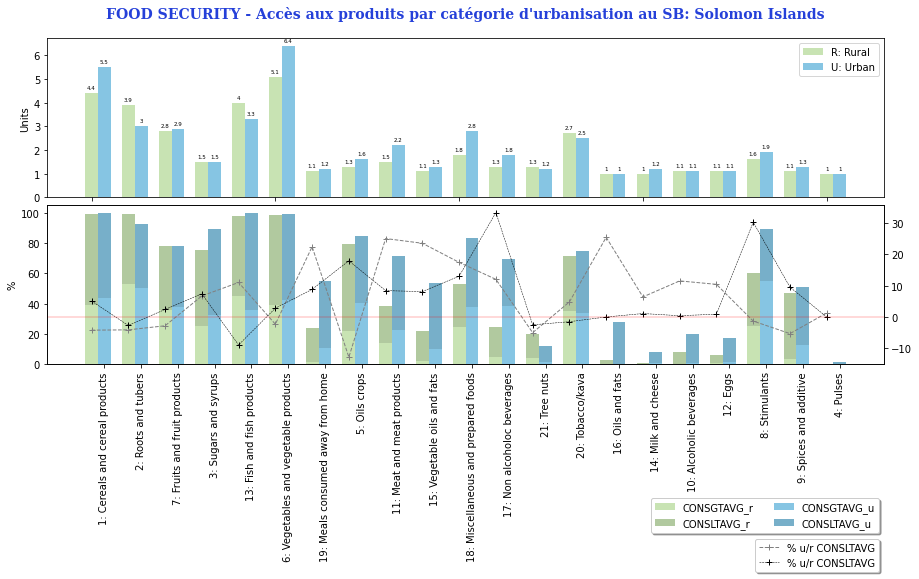

In [43]:
## GRAPHIQUE 6.2
TITLE = "FOOD SECURITY - Accès aux produits par catégorie d'urbanisation au SB: Solomon Islands"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
age = {'R: Rural': df_pivot_pays_urb_AVGNPRDCONS['R: Rural'].to_list(),
       'U: Urban': df_pivot_pays_urb_AVGNPRDCONS['U: Urban'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#C8E3B3', '#86C5E3']

i=0
for attribute, measurement in age.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_r = ['#C8E3B3', '#B1C99F']
bar_colors_u = ['#86C5E3', '#77AFC9']

pourcentages_r= {"CONSGTAVG_r": df_pivot_pays_urb_CONSGTAVG['R: Rural'].to_list(),
                 "CONSLTAVG_r": df_pivot_pays_urb_CONSLTAVG['R: Rural'].to_list(),
                }

pourcentages_u= {"CONSGTAVG_u": df_pivot_pays_urb_CONSGTAVG['U: Urban'].to_list(),
                 "CONSLTAVG_u": df_pivot_pays_urb_CONSLTAVG['U: Urban'].to_list(),
                }


x = np.arange(len(categories))

i=0
bottom_r = np.zeros(len(df_pivot_pays_urb_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_r.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_r, color=bar_colors_r[i])
    bottom_r += pourcentage
    i += 1

j=0
bottom_u = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_u.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_u, color=bar_colors_u[j])
    bottom_u += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_urb_CONSLTAVG.index.values, df_pivot_pays_urb_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% u/r CONSLTAVG')
ax2.plot(df_pivot_pays_urb_CONSGTAVG.index.values, df_pivot_pays_urb_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% u/r CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [44]:
## Analyse n°6
# LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_urb = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
#                             (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_urb_AVGNPRDCONS = df_pays_urb[df_pays_urb['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_urb_AVGNPRDCONS = df_pays_urb_AVGNPRDCONS.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_AVGNPRDCONS= df_pays_urb_AVGNPRDCONS.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_AVGNPRDCONS = df_pivot_pays_urb_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_urb_AVGNPRDCONS)

## CONSLTAVG
df_pays_urb_CONSLTAVG = df_pays_urb[df_pays_urb['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_urb_CONSLTAVG = df_pays_urb_CONSLTAVG.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_CONSLTAVG= df_pays_urb_CONSLTAVG.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_CONSLTAVG = df_pivot_pays_urb_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_urb_CONSLTAVG['ECART']=df_pivot_pays_urb_CONSLTAVG['U: Urban']-df_pivot_pays_urb_CONSLTAVG['R: Rural']
# print(df_pivot_pays_urb_CONSLTAVG)

## CONSGTAVG
df_pays_urb_CONSGTAVG = df_pays_urb[df_pays_urb['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_urb_CONSGTAVG = df_pays_urb_CONSGTAVG.groupby(['URBANISATION','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_urb_CONSGTAVG= df_pays_urb_CONSGTAVG.pivot_table(columns='URBANISATION', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_urb_CONSGTAVG = df_pivot_pays_urb_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_urb_CONSGTAVG['ECART']=df_pivot_pays_urb_CONSGTAVG['U: Urban']-df_pivot_pays_urb_CONSGTAVG['R: Rural']
# print(df_pivot_pays_urb_CONSGTAVG)

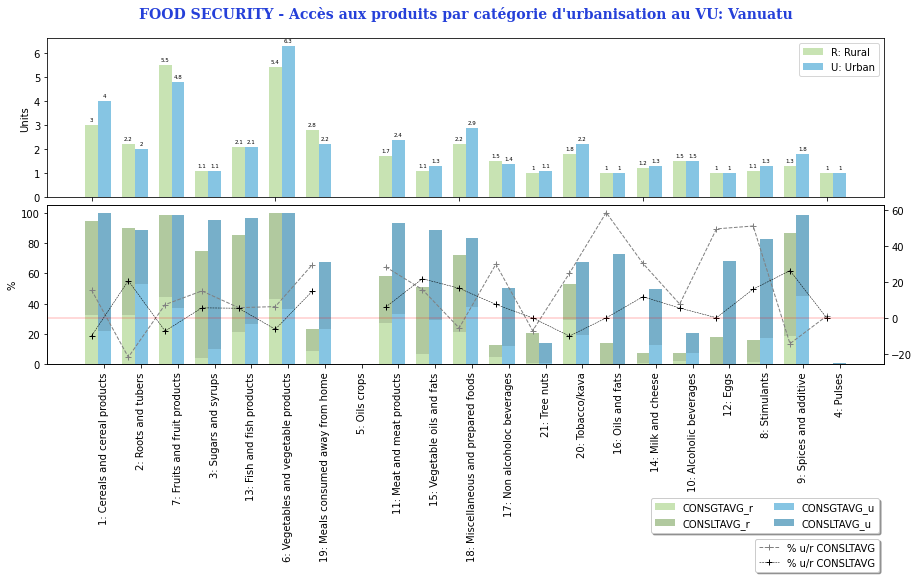

In [45]:
## GRAPHIQUE 6.3
TITLE = "FOOD SECURITY - Accès aux produits par catégorie d'urbanisation au VU: Vanuatu"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
age = {'R: Rural': df_pivot_pays_urb_AVGNPRDCONS['R: Rural'].to_list(),
       'U: Urban': df_pivot_pays_urb_AVGNPRDCONS['U: Urban'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#C8E3B3', '#86C5E3']

i=0
for attribute, measurement in age.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_sex_CONSLTAVG.index.to_list()
bar_colors_r = ['#C8E3B3', '#B1C99F']
bar_colors_u = ['#86C5E3', '#77AFC9']

pourcentages_r= {"CONSGTAVG_r": df_pivot_pays_urb_CONSGTAVG['R: Rural'].to_list(),
                 "CONSLTAVG_r": df_pivot_pays_urb_CONSLTAVG['R: Rural'].to_list(),
                }

pourcentages_u= {"CONSGTAVG_u": df_pivot_pays_urb_CONSGTAVG['U: Urban'].to_list(),
                 "CONSLTAVG_u": df_pivot_pays_urb_CONSLTAVG['U: Urban'].to_list(),
                }


x = np.arange(len(categories))

i=0
bottom_r = np.zeros(len(df_pivot_pays_urb_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_r.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_r, color=bar_colors_r[i])
    bottom_r += pourcentage
    i += 1

j=0
bottom_u = np.zeros(len(df_pivot_pays_age_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_u.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_u, color=bar_colors_u[j])
    bottom_u += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_urb_CONSLTAVG.index.values, df_pivot_pays_urb_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% u/r CONSLTAVG')
ax2.plot(df_pivot_pays_urb_CONSGTAVG.index.values, df_pivot_pays_urb_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% u/r CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [46]:
## Analyse n°7
LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_pov = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
#                             (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_pov_AVGNPRDCONS = df_pays_pov[df_pays_pov['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_pov_AVGNPRDCONS = df_pays_pov_AVGNPRDCONS.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_AVGNPRDCONS= df_pays_pov_AVGNPRDCONS.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_AVGNPRDCONS = df_pivot_pays_pov_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_pov_AVGNPRDCONS)

## CONSLTAVG
df_pays_pov_CONSLTAVG = df_pays_pov[df_pays_pov['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_pov_CONSLTAVG = df_pays_pov_CONSLTAVG.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_CONSLTAVG= df_pays_pov_CONSLTAVG.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_CONSLTAVG = df_pivot_pays_pov_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_pov_CONSLTAVG['ECART']=df_pivot_pays_pov_CONSLTAVG['NOP: No poverty']-df_pivot_pays_pov_CONSLTAVG['POV: Poverty']
# print(df_pivot_pays_pov_CONSLTAVG)

## CONSGTAVG
df_pays_pov_CONSGTAVG = df_pays_pov[df_pays_pov['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_pov_CONSGTAVG = df_pays_pov_CONSGTAVG.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_CONSGTAVG= df_pays_pov_CONSGTAVG.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_CONSGTAVG = df_pivot_pays_pov_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_pov_CONSGTAVG['ECART']=df_pivot_pays_pov_CONSGTAVG['NOP: No poverty']-df_pivot_pays_pov_CONSGTAVG['POV: Poverty']
# print(df_pivot_pays_pov_CONSGTAVG)

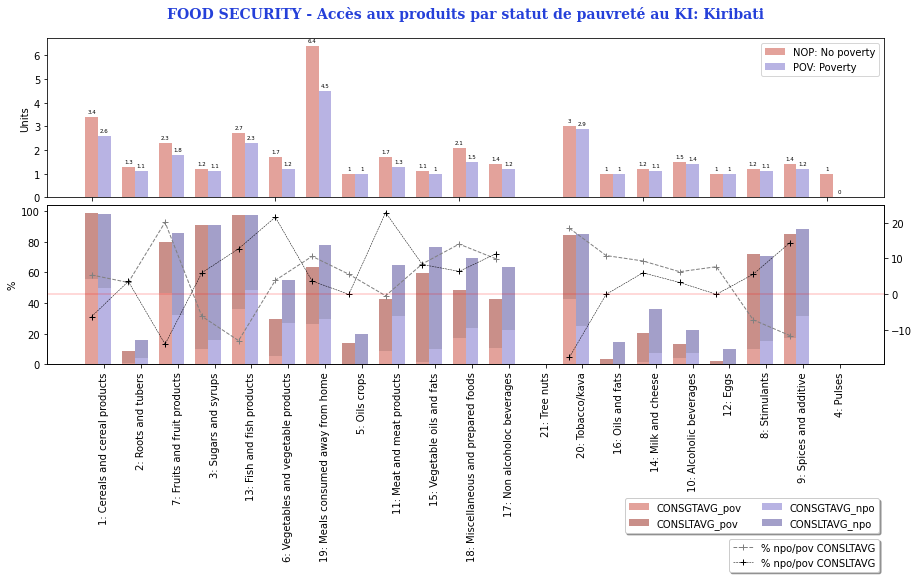

In [47]:
## GRAPHIQUE 7.1
TITLE = "FOOD SECURITY - Accès aux produits par statut de pauvreté au KI: Kiribati"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
pov = {'NOP: No poverty': df_pivot_pays_pov_AVGNPRDCONS['NOP: No poverty'].to_list(),
       'POV: Poverty': df_pivot_pays_pov_AVGNPRDCONS['POV: Poverty'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in pov.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_pov_CONSLTAVG.index.to_list()
bar_colors_pov = ['#E3A29B', '#C98F89']
bar_colors_npo = ['#B8B3E3', '#A39FC9']

pourcentages_pov= {"CONSGTAVG_pov": df_pivot_pays_pov_CONSGTAVG['POV: Poverty'].to_list(),
                 "CONSLTAVG_pov": df_pivot_pays_pov_CONSLTAVG['POV: Poverty'].to_list(),
                }

pourcentages_npo= {"CONSGTAVG_npo": df_pivot_pays_pov_CONSGTAVG['NOP: No poverty'].to_list(),
                 "CONSLTAVG_npo": df_pivot_pays_pov_CONSLTAVG['NOP: No poverty'].to_list(),
                }


x = np.arange(len(categories))

i=0
bottom_pov = np.zeros(len(df_pivot_pays_pov_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_pov.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_pov, color=bar_colors_pov[i])
    bottom_pov += pourcentage
    i += 1

j=0
bottom_npo = np.zeros(len(df_pivot_pays_pov_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_npo.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_npo, color=bar_colors_npo[j])
    bottom_npo += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_pov_CONSLTAVG.index.values, df_pivot_pays_pov_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% npo/pov CONSLTAVG')
ax2.plot(df_pivot_pays_pov_CONSGTAVG.index.values, df_pivot_pays_pov_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% npo/pov CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [48]:
## Analyse n°7
# LISTE_PAYS = ['KI: Kiribati']
LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_pov = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
#                             (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_pov_AVGNPRDCONS = df_pays_pov[df_pays_pov['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_pov_AVGNPRDCONS = df_pays_pov_AVGNPRDCONS.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_AVGNPRDCONS= df_pays_pov_AVGNPRDCONS.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_AVGNPRDCONS = df_pivot_pays_pov_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_pov_AVGNPRDCONS)

## CONSLTAVG
df_pays_pov_CONSLTAVG = df_pays_pov[df_pays_pov['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_pov_CONSLTAVG = df_pays_pov_CONSLTAVG.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_CONSLTAVG= df_pays_pov_CONSLTAVG.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_CONSLTAVG = df_pivot_pays_pov_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_pov_CONSLTAVG['ECART']=df_pivot_pays_pov_CONSLTAVG['NOP: No poverty']-df_pivot_pays_pov_CONSLTAVG['POV: Poverty']
# print(df_pivot_pays_pov_CONSLTAVG)

## CONSGTAVG
df_pays_pov_CONSGTAVG = df_pays_pov[df_pays_pov['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_pov_CONSGTAVG = df_pays_pov_CONSGTAVG.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_CONSGTAVG= df_pays_pov_CONSGTAVG.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_CONSGTAVG = df_pivot_pays_pov_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_pov_CONSGTAVG['ECART']=df_pivot_pays_pov_CONSGTAVG['NOP: No poverty']-df_pivot_pays_pov_CONSGTAVG['POV: Poverty']
# print(df_pivot_pays_pov_CONSGTAVG)

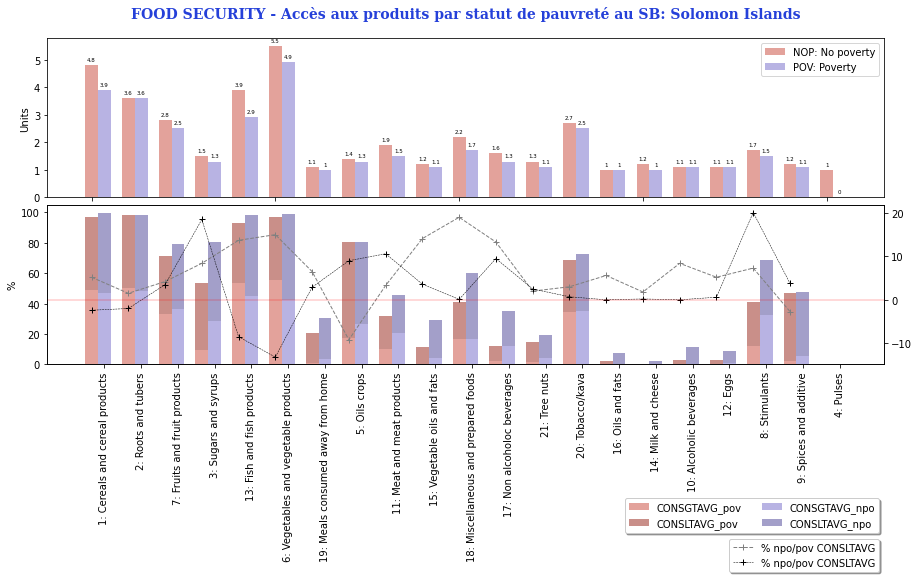

In [49]:
## GRAPHIQUE 7.2
TITLE = "FOOD SECURITY - Accès aux produits par statut de pauvreté au SB: Solomon Islands"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
pov = {'NOP: No poverty': df_pivot_pays_pov_AVGNPRDCONS['NOP: No poverty'].to_list(),
       'POV: Poverty': df_pivot_pays_pov_AVGNPRDCONS['POV: Poverty'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in pov.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_pov_CONSLTAVG.index.to_list()
bar_colors_pov = ['#E3A29B', '#C98F89']
bar_colors_npo = ['#B8B3E3', '#A39FC9']

pourcentages_pov= {"CONSGTAVG_pov": df_pivot_pays_pov_CONSGTAVG['POV: Poverty'].to_list(),
                 "CONSLTAVG_pov": df_pivot_pays_pov_CONSLTAVG['POV: Poverty'].to_list(),
                }

pourcentages_npo= {"CONSGTAVG_npo": df_pivot_pays_pov_CONSGTAVG['NOP: No poverty'].to_list(),
                 "CONSLTAVG_npo": df_pivot_pays_pov_CONSLTAVG['NOP: No poverty'].to_list(),
                }


x = np.arange(len(categories))

i=0
bottom_pov = np.zeros(len(df_pivot_pays_pov_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_pov.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_pov, color=bar_colors_pov[i])
    bottom_pov += pourcentage
    i += 1

j=0
bottom_npo = np.zeros(len(df_pivot_pays_pov_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_npo.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_npo, color=bar_colors_npo[j])
    bottom_npo += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_pov_CONSLTAVG.index.values, df_pivot_pays_pov_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% npo/pov CONSLTAVG')
ax2.plot(df_pivot_pays_pov_CONSGTAVG.index.values, df_pivot_pays_pov_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% npo/pov CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [50]:
## Analyse n°7
# LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_pov = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
#                             (df_pays['POVERTY'] == '_T: Total') & \
                            (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_pov_AVGNPRDCONS = df_pays_pov[df_pays_pov['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_pov_AVGNPRDCONS = df_pays_pov_AVGNPRDCONS.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_AVGNPRDCONS= df_pays_pov_AVGNPRDCONS.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_AVGNPRDCONS = df_pivot_pays_pov_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_pov_AVGNPRDCONS)

## CONSLTAVG
df_pays_pov_CONSLTAVG = df_pays_pov[df_pays_pov['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_pov_CONSLTAVG = df_pays_pov_CONSLTAVG.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_CONSLTAVG= df_pays_pov_CONSLTAVG.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_CONSLTAVG = df_pivot_pays_pov_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_pov_CONSLTAVG['ECART']=df_pivot_pays_pov_CONSLTAVG['NOP: No poverty']-df_pivot_pays_pov_CONSLTAVG['POV: Poverty']
# print(df_pivot_pays_pov_CONSLTAVG)

## CONSGTAVG
df_pays_pov_CONSGTAVG = df_pays_pov[df_pays_pov['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_pov_CONSGTAVG = df_pays_pov_CONSGTAVG.groupby(['POVERTY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_pov_CONSGTAVG= df_pays_pov_CONSGTAVG.pivot_table(columns='POVERTY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_pov_CONSGTAVG = df_pivot_pays_pov_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_pov_CONSGTAVG['ECART']=df_pivot_pays_pov_CONSGTAVG['NOP: No poverty']-df_pivot_pays_pov_CONSGTAVG['POV: Poverty']
# print(df_pivot_pays_pov_CONSGTAVG)

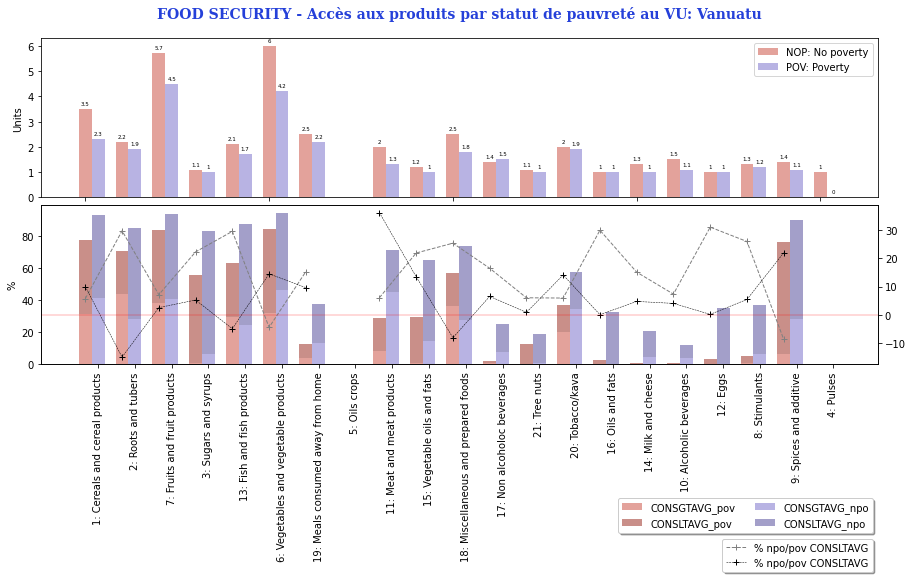

In [51]:
## GRAPHIQUE 7.3
TITLE = "FOOD SECURITY - Accès aux produits par statut de pauvreté au VU: Vanuatu"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
pov = {'NOP: No poverty': df_pivot_pays_pov_AVGNPRDCONS['NOP: No poverty'].to_list(),
       'POV: Poverty': df_pivot_pays_pov_AVGNPRDCONS['POV: Poverty'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in pov.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_pov_CONSLTAVG.index.to_list()
bar_colors_pov = ['#E3A29B', '#C98F89']
bar_colors_npo = ['#B8B3E3', '#A39FC9']

pourcentages_pov= {"CONSGTAVG_pov": df_pivot_pays_pov_CONSGTAVG['POV: Poverty'].to_list(),
                 "CONSLTAVG_pov": df_pivot_pays_pov_CONSLTAVG['POV: Poverty'].to_list(),
                }

pourcentages_npo= {"CONSGTAVG_npo": df_pivot_pays_pov_CONSGTAVG['NOP: No poverty'].to_list(),
                 "CONSLTAVG_npo": df_pivot_pays_pov_CONSLTAVG['NOP: No poverty'].to_list(),
                }


x = np.arange(len(categories))

i=0
bottom_pov = np.zeros(len(df_pivot_pays_pov_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_pov.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_pov, color=bar_colors_pov[i])
    bottom_pov += pourcentage
    i += 1

j=0
bottom_npo = np.zeros(len(df_pivot_pays_pov_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_npo.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_npo, color=bar_colors_npo[j])
    bottom_npo += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_pov_CONSLTAVG.index.values, df_pivot_pays_pov_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% npo/pov CONSLTAVG')
ax2.plot(df_pivot_pays_pov_CONSGTAVG.index.values, df_pivot_pays_pov_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% npo/pov CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [52]:
## Analyse n°8
LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
# LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_fin = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total')
#                             (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_fin_AVGNPRDCONS = df_pays_fin[df_pays_fin['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_fin_AVGNPRDCONS = df_pays_fin_AVGNPRDCONS.groupby(['FOOD_SECURITY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_fin_AVGNPRDCONS= df_pays_fin_AVGNPRDCONS.pivot_table(columns='FOOD_SECURITY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_fin_AVGNPRDCONS = df_pivot_pays_fin_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_fin_AVGNPRDCONS)

## CONSLTAVG
df_pays_fin_CONSLTAVG = df_pays_fin[df_pays_fin['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_fin_CONSLTAVG = df_pays_fin_CONSLTAVG.groupby(['FOOD_SECURITY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_fin_CONSLTAVG= df_pays_fin_CONSLTAVG.pivot_table(columns='FOOD_SECURITY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_fin_CONSLTAVG = df_pivot_pays_fin_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_fin_CONSLTAVG['ECART']=df_pivot_pays_fin_CONSLTAVG['FOODSEC: Food secure or mildly food insecur']-df_pivot_pays_fin_CONSLTAVG['FOODINS: Moderately or severely food insecure']
# print(df_pivot_pays_fin_CONSLTAVG)

## CONSGTAVG
df_pays_fin_CONSGTAVG = df_pays_fin[df_pays_fin['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_fin_CONSGTAVG = df_pays_fin_CONSGTAVG.groupby(['FOOD_SECURITY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_fin_CONSGTAVG= df_pays_fin_CONSGTAVG.pivot_table(columns='FOOD_SECURITY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_fin_CONSGTAVG = df_pivot_pays_fin_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_fin_CONSGTAVG['ECART']=df_pivot_pays_fin_CONSGTAVG['FOODSEC: Food secure or mildly food insecur']-df_pivot_pays_fin_CONSGTAVG['FOODINS: Moderately or severely food insecure']
# print(df_pivot_pays_fin_CONSGTAVG)

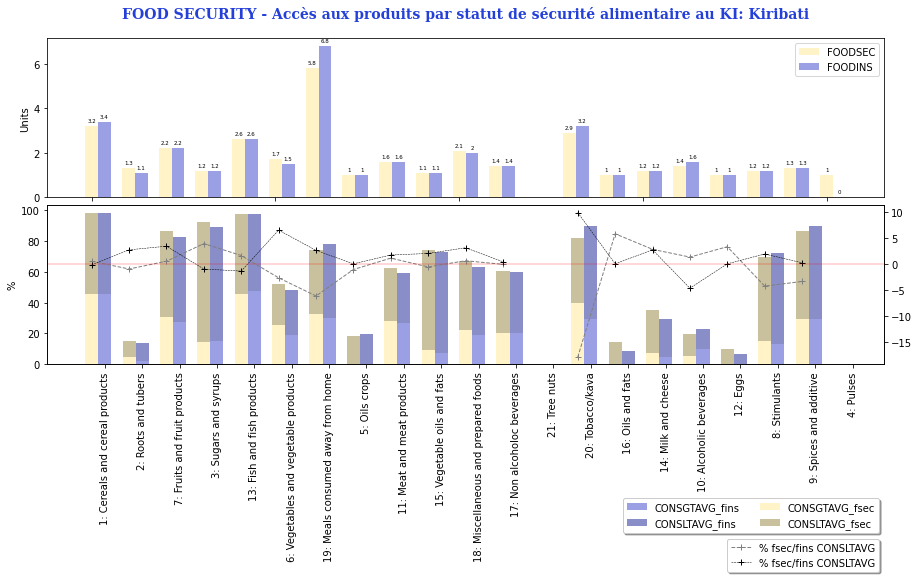

In [53]:
## GRAPHIQUE 8.1
TITLE = "FOOD SECURITY - Accès aux produits par statut de sécurité alimentaire au KI: Kiribati"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
fin = {'FOODSEC': df_pivot_pays_fin_AVGNPRDCONS['FOODSEC: Food secure or mildly food insecur'].to_list(),
       'FOODINS': df_pivot_pays_fin_AVGNPRDCONS['FOODINS: Moderately or severely food insecure'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#9AA0E3']

i=0
for attribute, measurement in fin.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_fin_CONSLTAVG.index.to_list()
bar_colors_fins = ['#9AA0E3', '#898EC9']
bar_colors_fsec = ['#FFF3C7', '#C9C09D']

pourcentages_fins= {"CONSGTAVG_fins": df_pivot_pays_fin_CONSGTAVG['FOODINS: Moderately or severely food insecure'].to_list(),
                    "CONSLTAVG_fins": df_pivot_pays_fin_CONSLTAVG['FOODINS: Moderately or severely food insecure'].to_list(),
                   }

pourcentages_fsec= {"CONSGTAVG_fsec": df_pivot_pays_fin_CONSGTAVG['FOODSEC: Food secure or mildly food insecur'].to_list(),
                    "CONSLTAVG_fsec": df_pivot_pays_fin_CONSLTAVG['FOODSEC: Food secure or mildly food insecur'].to_list(),
                   }


x = np.arange(len(categories))

i=0
bottom_fins = np.zeros(len(df_pivot_pays_fin_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_fins.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_fins, color=bar_colors_fins[i])
    bottom_fins += pourcentage
    i += 1

j=0
bottom_fsec = np.zeros(len(df_pivot_pays_fin_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_fsec.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_fsec, color=bar_colors_fsec[j])
    bottom_fsec += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_fin_CONSLTAVG.index.values, df_pivot_pays_fin_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% fsec/fins CONSLTAVG')
ax2.plot(df_pivot_pays_fin_CONSGTAVG.index.values, df_pivot_pays_fin_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% fsec/fins CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [54]:
## Analyse n°8
# LISTE_PAYS = ['KI: Kiribati']
# LISTE_PAYS = ['SB: Solomon Islands']
LISTE_PAYS = ['VU: Vanuatu']

df_pays = df_net[df_net['REGION'].isin(LISTE_PAYS)]
df_pays_fin = df_pays.loc[  (df_pays['GENRE'] == '_T: Total') & \
                            (df_pays['AGE'] == '_T: All ages') & \
                            (df_pays['URBANISATION'] == '_T: National') & \
                            (df_pays['POVERTY'] == '_T: Total')
#                             (df_pays['FOOD_SECURITY'] == '_T: Total')
                           ]
## AVGNPRDCONS
df_pays_fin_AVGNPRDCONS = df_pays_fin[df_pays_fin['INDICATEUR'] == 'AVGNPRDCONS: Average number of products consumed by household by food group']
df_pays_fin_AVGNPRDCONS = df_pays_fin_AVGNPRDCONS.groupby(['FOOD_SECURITY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_fin_AVGNPRDCONS= df_pays_fin_AVGNPRDCONS.pivot_table(columns='FOOD_SECURITY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_fin_AVGNPRDCONS = df_pivot_pays_fin_AVGNPRDCONS.reindex(GLOBAL_ORDER)
# print(df_pivot_pays_fin_AVGNPRDCONS)

## CONSLTAVG
df_pays_fin_CONSLTAVG = df_pays_fin[df_pays_fin['INDICATEUR'] == 'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']
df_pays_fin_CONSLTAVG = df_pays_fin_CONSLTAVG.groupby(['FOOD_SECURITY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_fin_CONSLTAVG= df_pays_fin_CONSLTAVG.pivot_table(columns='FOOD_SECURITY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_fin_CONSLTAVG = df_pivot_pays_fin_CONSLTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_fin_CONSLTAVG['ECART']=df_pivot_pays_fin_CONSLTAVG['FOODSEC: Food secure or mildly food insecur']-df_pivot_pays_fin_CONSLTAVG['FOODINS: Moderately or severely food insecure']
# print(df_pivot_pays_fin_CONSLTAVG)

## CONSGTAVG
df_pays_fin_CONSGTAVG = df_pays_fin[df_pays_fin['INDICATEUR'] == 'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group']
df_pays_fin_CONSGTAVG = df_pays_fin_CONSGTAVG.groupby(['FOOD_SECURITY','FOOD_CATEGORY']).agg({'VALUE':'sum'}).rename(columns={"VALUE":"Unit"})
df_pivot_pays_fin_CONSGTAVG= df_pays_fin_CONSGTAVG.pivot_table(columns='FOOD_SECURITY', index='FOOD_CATEGORY', values='Unit')
df_pivot_pays_fin_CONSGTAVG = df_pivot_pays_fin_CONSGTAVG.reindex(GLOBAL_ORDER)
df_pivot_pays_fin_CONSGTAVG['ECART']=df_pivot_pays_fin_CONSGTAVG['FOODSEC: Food secure or mildly food insecur']-df_pivot_pays_fin_CONSGTAVG['FOODINS: Moderately or severely food insecure']
# print(df_pivot_pays_fin_CONSGTAVG)

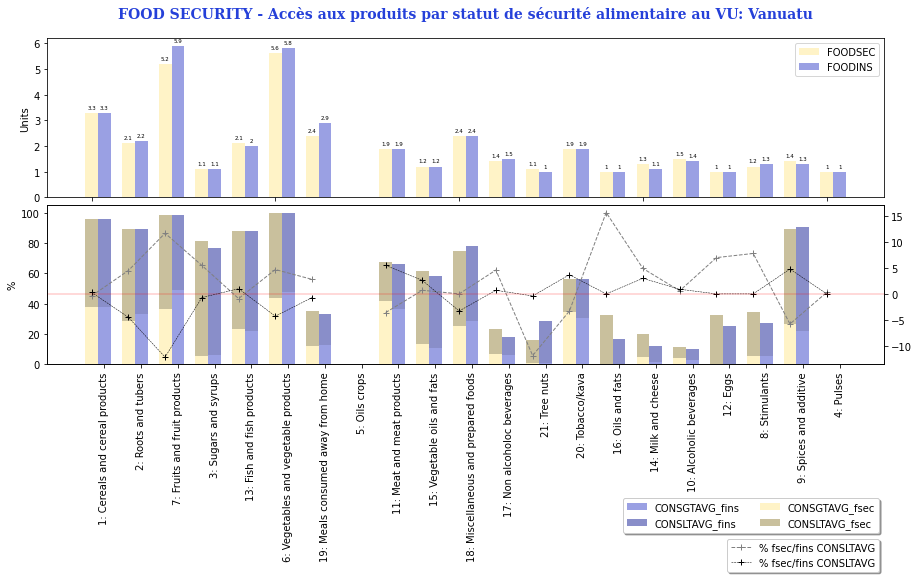

In [55]:
## GRAPHIQUE 8.2
TITLE = "FOOD SECURITY - Accès aux produits par statut de sécurité alimentaire au VU: Vanuatu"
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax[0].set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 14},pad=20)

## 1
categories = df_pivot_pays_total_AVGNPRDCONS.index.to_list()
fin = {'FOODSEC': df_pivot_pays_fin_AVGNPRDCONS['FOODSEC: Food secure or mildly food insecur'].to_list(),
       'FOODINS': df_pivot_pays_fin_AVGNPRDCONS['FOODINS: Moderately or severely food insecure'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#9AA0E3']

i=0
for attribute, measurement in fin.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax[0].bar_label(rects, padding=3, fontsize=5.5)
    multiplier += 1
    i+=1

ax[0].legend(loc='upper right')
ax[0].set_xticklabels([])

## 2
width = 0.35
categories = df_pivot_pays_fin_CONSLTAVG.index.to_list()
bar_colors_fins = ['#9AA0E3', '#898EC9']
bar_colors_fsec = ['#FFF3C7', '#C9C09D']

pourcentages_fins= {"CONSGTAVG_fins": df_pivot_pays_fin_CONSGTAVG['FOODINS: Moderately or severely food insecure'].to_list(),
                    "CONSLTAVG_fins": df_pivot_pays_fin_CONSLTAVG['FOODINS: Moderately or severely food insecure'].to_list(),
                   }

pourcentages_fsec= {"CONSGTAVG_fsec": df_pivot_pays_fin_CONSGTAVG['FOODSEC: Food secure or mildly food insecur'].to_list(),
                    "CONSLTAVG_fsec": df_pivot_pays_fin_CONSLTAVG['FOODSEC: Food secure or mildly food insecur'].to_list(),
                   }


x = np.arange(len(categories))

i=0
bottom_fins = np.zeros(len(df_pivot_pays_fin_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_fins.items():
    p = ax[1].bar(x+width, pourcentage, width, label=boolean, bottom=bottom_fins, color=bar_colors_fins[i])
    bottom_fins += pourcentage
    i += 1

j=0
bottom_fsec = np.zeros(len(df_pivot_pays_fin_CONSGTAVG.index.to_list()))
for boolean, pourcentage in pourcentages_fsec.items():
    p = ax[1].bar(x, pourcentage, width, label=boolean, bottom=bottom_fsec, color=bar_colors_fsec[j])
    bottom_fsec += pourcentage
    j += 1


ax2 = ax[1].twinx()
ax2.plot(df_pivot_pays_fin_CONSLTAVG.index.values, df_pivot_pays_fin_CONSLTAVG['ECART'], 'grey',linestyle='--', marker='+',linewidth=1, label='% fsec/fins CONSLTAVG')
ax2.plot(df_pivot_pays_fin_CONSGTAVG.index.values, df_pivot_pays_fin_CONSGTAVG['ECART'], 'black',linestyle='--', marker='+',linewidth=0.5, label='% fsec/fins CONSLTAVG')
ax2.axhline(0, color='red', alpha=0.2)

ax[0].set_ylabel('Units')
ax[1].set_ylabel('%')

ax[1].set_xticks(x + width, categories)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=10, rotation=90)
ax[1].legend(loc="right",bbox_to_anchor=(0,0,1,-1.9), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-2.4), ncol=1, fancybox=True, shadow=True)

In [125]:
## Analyse n°9
LISTE_REGION = ['KI: Kiribati','KI-A: Northern Kiribati','KI-B: South Tarawa','KI-C: Central Kiribati','KI-D: Southern Kiribati','KI-E: Line & Phoenix']
# LISTE_REGION = ['SB: Solomon Islands','SB-1: Choiseul','SB-2: Western','SB-3: Isabel','SB-4: Central','SB-5: Rennell-Bell',\
#                 'SB-6: Guadalcanal','SB-7: Malaita','SB-8: Makira-Ulawa','SB-9: Temotu','SB-10: Honiara']
# LISTE_REGION = ['VU: Vanuatu', 'VU-1: Torba','VU-2: Sanma','VU-3: Penama','VU-4: Malampa','VU-5: Shefa','VU-6: Tafea']

df_region = df_net[df_net['REGION'].isin(LISTE_REGION)]
df_region_total = df_region.loc[(df_region['GENRE'] == '_T: Total') & \
                                (df_region['AGE'] == '_T: All ages') & \
                                (df_region['URBANISATION'] == '_T: National') & \
                                (df_region['POVERTY'] == '_T: Total') & \
                                (df_region['FOOD_SECURITY'] == '_T: Total')
                               ]

LISTE_INDICATEUR_1 = ['AQAA: Average quantity as acquired','AVGDEC: Average Dietary Energy Consumption',\
                   'AVGEQ: Average edible quantity','AVGEXP: Average expenditures']
LISTE_INDICATEUR_2 = ['CONSAL1: Percentage of HH who consumed at least one product of the group',\
                     'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group', \
                     'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']

df_region_total_1 = df_region_total[df_region_total['INDICATEUR'].isin(LISTE_INDICATEUR_1)]
df_region_total_2 = df_region_total[df_region_total['INDICATEUR'].isin(LISTE_INDICATEUR_2)]

df_gb_region_total_1 = df_region_total_1.groupby(['REGION','INDICATEUR']).agg({'VALUE': 'sum'})
df_gb_region_total_2 = df_region_total_2.groupby(['REGION','INDICATEUR']).agg(MOYENNE=('VALUE', 'mean'), STD=('VALUE', 'std'))

df_pivot_region_total_1= df_gb_region_total_1.pivot_table(columns='INDICATEUR', index='REGION', values='VALUE')
df_pivot_region_total_2= df_gb_region_total_2.pivot_table(columns='INDICATEUR', index='REGION', values='MOYENNE')
df_pivot_region_total_3= df_gb_region_total_2.pivot_table(columns='INDICATEUR', index='REGION', values='STD')

df_pivot_region_total_1 = df_pivot_region_total_1.rename(columns={'AQAA: Average quantity as acquired': 'AQAA_SUM', 
                                                                  'AVGDEC: Average Dietary Energy Consumption':'AVGDEC_SUM',
                                                                  'AVGEQ: Average edible quantity':'AVGEQ_SUM',
                                                                  'AVGEXP: Average expenditures':'AVGEXP_SUM'})

df_pivot_region_total_2 = df_pivot_region_total_2.rename(columns={'CONSAL1: Percentage of HH who consumed at least one product of the group': 'CONSAL1_MEAN', 
                                                                  'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group':'CONSGTAVG_MEAN',
                                                                  'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group':'CONSLTAVG_MEAN'})

df_pivot_region_total_3 = df_pivot_region_total_3.rename(columns={'CONSAL1: Percentage of HH who consumed at least one product of the group': 'CONSAL1_STD', 
                                                                  'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group':'CONSGTAVG_STD',
                                                                  'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group':'CONSLTAVG_STD'})

df_pivot_region_total_1_pct = df_pivot_region_total_1.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)
df_pivot_region_total_2_pct = df_pivot_region_total_2.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)
df_pivot_region_total_3_pct = df_pivot_region_total_3.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)

df_pivot_region_final = pd.concat([df_pivot_region_total_1, df_pivot_region_total_2], axis=1)

df_pivot_region_final_pct = pd.concat([df_pivot_region_total_1_pct, df_pivot_region_total_2_pct], axis=1)
df_pivot_region_final_pct = df_pivot_region_final_pct[:-1]

# print(df_pivot_region_final)

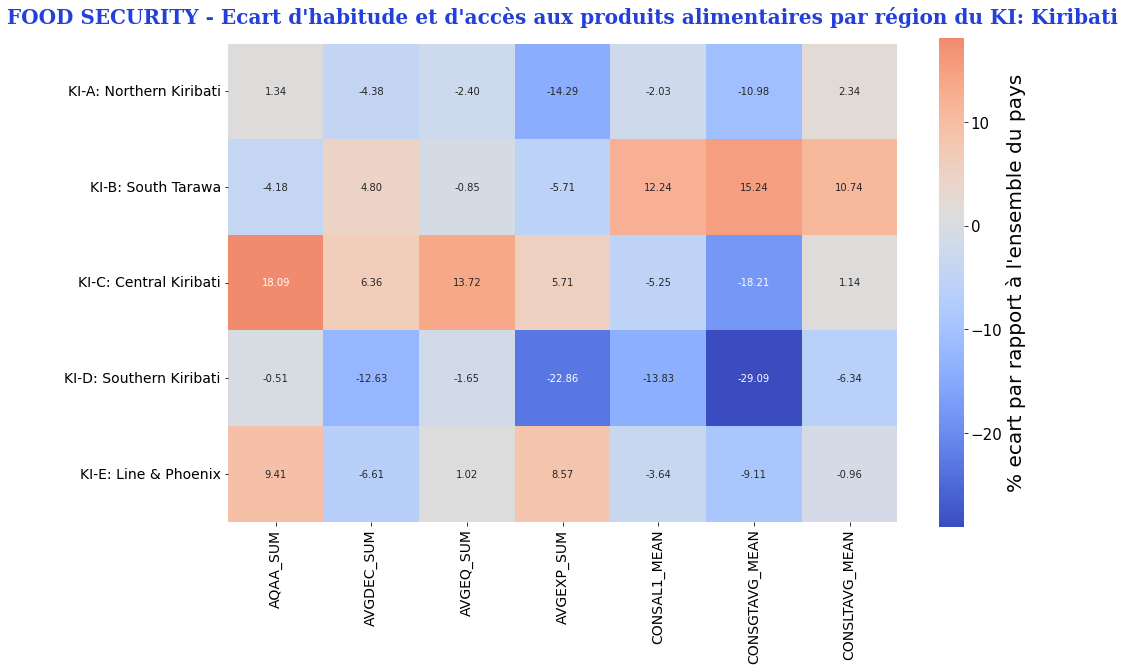

In [124]:
## GRAPHIQUE 9.1
TITLE = "FOOD SECURITY - Ecart d'habitude et d'accès aux produits alimentaires par région du KI: Kiribati"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_region_final_pct, annot=True, square=True, cmap="coolwarm", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f',center=1)
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel("% ecart par rapport à l'ensemble du pays", size=20)
ax.figure.axes[-1].tick_params(labelsize=15)

xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)


In [126]:
## Analyse n°9
#LISTE_REGION = ['KI: Kiribati','KI-A: Northern Kiribati','KI-B: South Tarawa','KI-C: Central Kiribati','KI-D: Southern Kiribati','KI-E: Line & Phoenix']
LISTE_REGION = ['SB: Solomon Islands','SB-1: Choiseul','SB-2: Western','SB-3: Isabel','SB-4: Central','SB-5: Rennell-Bell',\
                 'SB-6: Guadalcanal','SB-7: Malaita','SB-8: Makira-Ulawa','SB-9: Temotu','SB-10: Honiara']
# LISTE_REGION = ['VU: Vanuatu', 'VU-1: Torba','VU-2: Sanma','VU-3: Penama','VU-4: Malampa','VU-5: Shefa','VU-6: Tafea']

df_region = df_net[df_net['REGION'].isin(LISTE_REGION)]
df_region_total = df_region.loc[(df_region['GENRE'] == '_T: Total') & \
                                (df_region['AGE'] == '_T: All ages') & \
                                (df_region['URBANISATION'] == '_T: National') & \
                                (df_region['POVERTY'] == '_T: Total') & \
                                (df_region['FOOD_SECURITY'] == '_T: Total')
                               ]

LISTE_INDICATEUR_1 = ['AQAA: Average quantity as acquired','AVGDEC: Average Dietary Energy Consumption',\
                   'AVGEQ: Average edible quantity','AVGEXP: Average expenditures']
LISTE_INDICATEUR_2 = ['CONSAL1: Percentage of HH who consumed at least one product of the group',\
                     'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group', \
                     'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']

df_region_total_1 = df_region_total[df_region_total['INDICATEUR'].isin(LISTE_INDICATEUR_1)]
df_region_total_2 = df_region_total[df_region_total['INDICATEUR'].isin(LISTE_INDICATEUR_2)]

df_gb_region_total_1 = df_region_total_1.groupby(['REGION','INDICATEUR']).agg({'VALUE': 'sum'})
df_gb_region_total_2 = df_region_total_2.groupby(['REGION','INDICATEUR']).agg(MOYENNE=('VALUE', 'mean'), STD=('VALUE', 'std'))

df_pivot_region_total_1= df_gb_region_total_1.pivot_table(columns='INDICATEUR', index='REGION', values='VALUE')
df_pivot_region_total_2= df_gb_region_total_2.pivot_table(columns='INDICATEUR', index='REGION', values='MOYENNE')
df_pivot_region_total_3= df_gb_region_total_2.pivot_table(columns='INDICATEUR', index='REGION', values='STD')

df_pivot_region_total_1 = df_pivot_region_total_1.rename(columns={'AQAA: Average quantity as acquired': 'AQAA_SUM', 
                                                                  'AVGDEC: Average Dietary Energy Consumption':'AVGDEC_SUM',
                                                                  'AVGEQ: Average edible quantity':'AVGEQ_SUM',
                                                                  'AVGEXP: Average expenditures':'AVGEXP_SUM'})

df_pivot_region_total_2 = df_pivot_region_total_2.rename(columns={'CONSAL1: Percentage of HH who consumed at least one product of the group': 'CONSAL1_MEAN', 
                                                                  'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group':'CONSGTAVG_MEAN',
                                                                  'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group':'CONSLTAVG_MEAN'})

df_pivot_region_total_3 = df_pivot_region_total_3.rename(columns={'CONSAL1: Percentage of HH who consumed at least one product of the group': 'CONSAL1_STD', 
                                                                  'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group':'CONSGTAVG_STD',
                                                                  'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group':'CONSLTAVG_STD'})

df_pivot_region_total_1_pct = df_pivot_region_total_1.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)
df_pivot_region_total_2_pct = df_pivot_region_total_2.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)
df_pivot_region_total_3_pct = df_pivot_region_total_3.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)

df_pivot_region_final = pd.concat([df_pivot_region_total_1, df_pivot_region_total_2], axis=1)

df_pivot_region_final_pct = pd.concat([df_pivot_region_total_1_pct, df_pivot_region_total_2_pct], axis=1)
df_pivot_region_final_pct = df_pivot_region_final_pct[:-1]

# print(df_pivot_region_final)

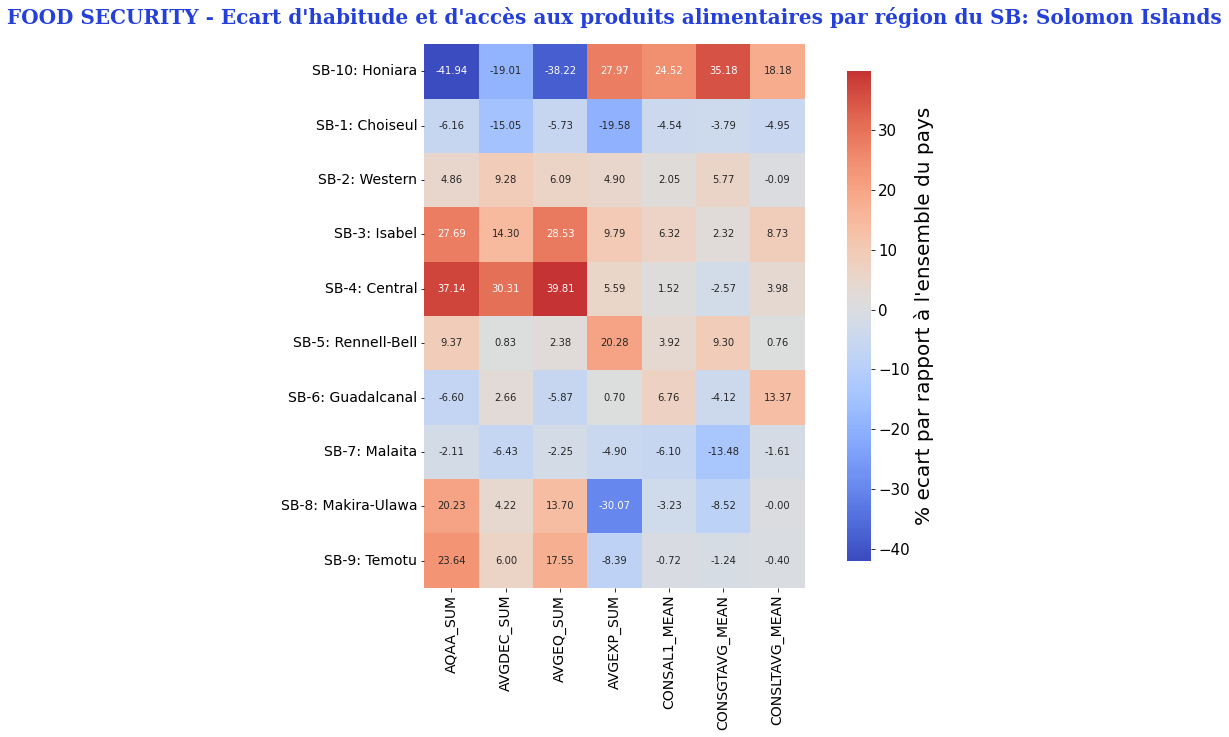

In [127]:
## GRAPHIQUE 9.2
TITLE = "FOOD SECURITY - Ecart d'habitude et d'accès aux produits alimentaires par région du SB: Solomon Islands"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_region_final_pct, annot=True, square=True, cmap="coolwarm", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f',center=1)
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel("% ecart par rapport à l'ensemble du pays", size=20)
ax.figure.axes[-1].tick_params(labelsize=15)

xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)

In [130]:
## Analyse n°9
#LISTE_REGION = ['KI: Kiribati','KI-A: Northern Kiribati','KI-B: South Tarawa','KI-C: Central Kiribati','KI-D: Southern Kiribati','KI-E: Line & Phoenix']
#LISTE_REGION = ['SB: Solomon Islands','SB-1: Choiseul','SB-2: Western','SB-3: Isabel','SB-4: Central','SB-5: Rennell-Bell',\
#                 'SB-6: Guadalcanal','SB-7: Malaita','SB-8: Makira-Ulawa','SB-9: Temotu','SB-10: Honiara']
LISTE_REGION = ['VU: Vanuatu', 'VU-1: Torba','VU-2: Sanma','VU-3: Penama','VU-4: Malampa','VU-5: Shefa','VU-6: Tafea']

df_region = df_net[df_net['REGION'].isin(LISTE_REGION)]
df_region_total = df_region.loc[(df_region['GENRE'] == '_T: Total') & \
                                (df_region['AGE'] == '_T: All ages') & \
                                (df_region['URBANISATION'] == '_T: National') & \
                                (df_region['POVERTY'] == '_T: Total') & \
                                (df_region['FOOD_SECURITY'] == '_T: Total')
                               ]

LISTE_INDICATEUR_1 = ['AQAA: Average quantity as acquired','AVGDEC: Average Dietary Energy Consumption',\
                   'AVGEQ: Average edible quantity','AVGEXP: Average expenditures']
LISTE_INDICATEUR_2 = ['CONSAL1: Percentage of HH who consumed at least one product of the group',\
                     'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group', \
                     'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group']

df_region_total_1 = df_region_total[df_region_total['INDICATEUR'].isin(LISTE_INDICATEUR_1)]
df_region_total_2 = df_region_total[df_region_total['INDICATEUR'].isin(LISTE_INDICATEUR_2)]

df_gb_region_total_1 = df_region_total_1.groupby(['REGION','INDICATEUR']).agg({'VALUE': 'sum'})
df_gb_region_total_2 = df_region_total_2.groupby(['REGION','INDICATEUR']).agg(MOYENNE=('VALUE', 'mean'), STD=('VALUE', 'std'))

df_pivot_region_total_1= df_gb_region_total_1.pivot_table(columns='INDICATEUR', index='REGION', values='VALUE')
df_pivot_region_total_2= df_gb_region_total_2.pivot_table(columns='INDICATEUR', index='REGION', values='MOYENNE')
df_pivot_region_total_3= df_gb_region_total_2.pivot_table(columns='INDICATEUR', index='REGION', values='STD')

df_pivot_region_total_1 = df_pivot_region_total_1.rename(columns={'AQAA: Average quantity as acquired': 'AQAA_SUM', 
                                                                  'AVGDEC: Average Dietary Energy Consumption':'AVGDEC_SUM',
                                                                  'AVGEQ: Average edible quantity':'AVGEQ_SUM',
                                                                  'AVGEXP: Average expenditures':'AVGEXP_SUM'})

df_pivot_region_total_2 = df_pivot_region_total_2.rename(columns={'CONSAL1: Percentage of HH who consumed at least one product of the group': 'CONSAL1_MEAN', 
                                                                  'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group':'CONSGTAVG_MEAN',
                                                                  'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group':'CONSLTAVG_MEAN'})

df_pivot_region_total_3 = df_pivot_region_total_3.rename(columns={'CONSAL1: Percentage of HH who consumed at least one product of the group': 'CONSAL1_STD', 
                                                                  'CONSGTAVG: Percentage of households who consumed more than the average number of products consumed in the group':'CONSGTAVG_STD',
                                                                  'CONSLTAVG: Percentage of households who consumed less than the average number of products consumed in the group':'CONSLTAVG_STD'})

df_pivot_region_total_1_pct = df_pivot_region_total_1.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)
df_pivot_region_total_2_pct = df_pivot_region_total_2.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)
df_pivot_region_total_3_pct = df_pivot_region_total_3.iloc[:, :].apply(lambda x: ((x - x.iloc[-1])/x.iloc[-1])*100)

df_pivot_region_final = pd.concat([df_pivot_region_total_1, df_pivot_region_total_2], axis=1)

df_pivot_region_final_pct = pd.concat([df_pivot_region_total_1_pct, df_pivot_region_total_2_pct], axis=1)
df_pivot_region_final_pct = df_pivot_region_final_pct[:-1]

print(df_pivot_region_final)

INDICATEUR     AQAA_SUM  AVGDEC_SUM  AVGEQ_SUM  AVGEXP_SUM  CONSAL1_MEAN  \
REGION                                                                     
VU-1: Torba      2358.5      2275.6     1759.1       326.2     44.726316   
VU-3: Penama     2527.0      2742.9     1928.0       296.8     51.757895   
VU-4: Malampa    2342.6      2801.8     1917.5       446.7     61.836842   
VU-6: Tafea      2282.7      3019.0     1985.9       560.0     72.700000   
VU: Vanuatu      2372.2      2758.3     1922.1       399.8     54.895000   

INDICATEUR     CONSGTAVG_MEAN  CONSLTAVG_MEAN  
REGION                                         
VU-1: Torba         15.978947       28.731579  
VU-3: Penama        15.826316       35.942105  
VU-4: Malampa       23.257895       38.573684  
VU-6: Tafea         22.430000       50.275000  
VU: Vanuatu         17.550000       37.350000  


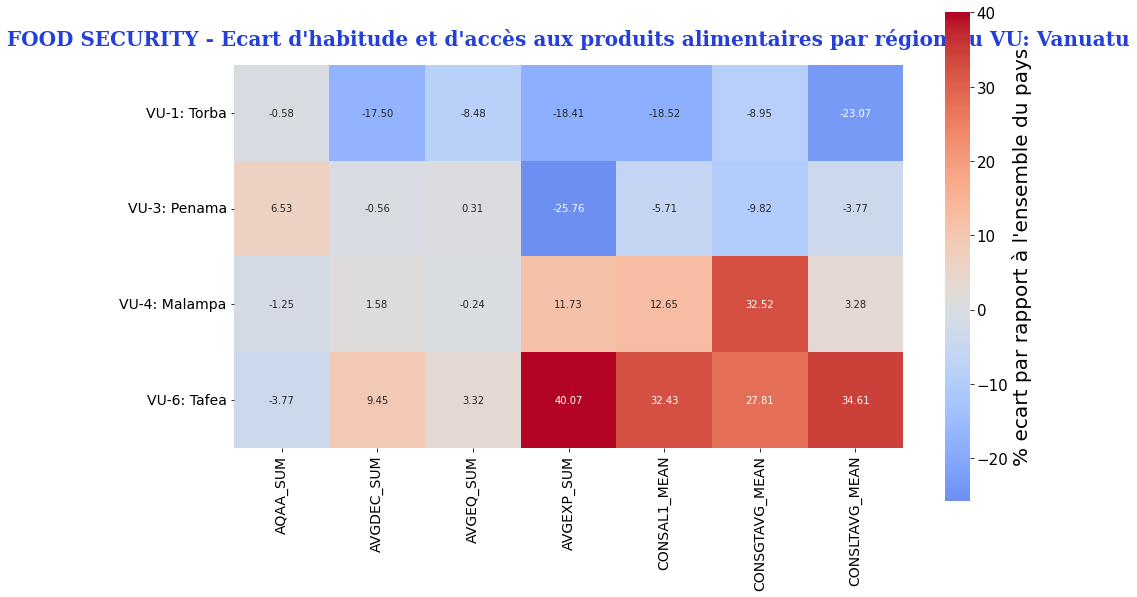

In [129]:
## GRAPHIQUE 9.3
TITLE = "FOOD SECURITY - Ecart d'habitude et d'accès aux produits alimentaires par région du VU: Vanuatu"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # Nombre et disposition des zones de dessin

ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#2540D9','weight': 'bold','size': 20},pad=20)
ax = sns.heatmap(df_pivot_region_final_pct, annot=True, square=True, cmap="coolwarm", cbar_kws={'label': '%', 'location' : 'right',"shrink": 0.9} ,fmt='.2f',center=1)
ax.set(xlabel="", ylabel="")
ax.figure.axes[-1].set_ylabel("% ecart par rapport à l'ensemble du pays", size=20)
ax.figure.axes[-1].tick_params(labelsize=15)

xa = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
ya = ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)